In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import shapely.vectorized as sv
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.colors import BoundaryNorm

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_statistic as ART_sta

import warnings
warnings.filterwarnings('ignore')

## Camparison between correction above parameters

In [2]:
correction1 = 'LLc'
correction2 = 'QDM'
correction3 = 'CDFt'
correction4 = 'QQc'

In [ ]:
frac = 0.7
seeds = [7, 19, 31, 53, 89, 127, 211, 307, 401, 509, 613, 727, 839, 947, 1051]
seeds = [7]

In [3]:
COMPUTERNAME = os.environ['COMPUTERNAME']
print(f'Computer: {COMPUTERNAME}')

if COMPUTERNAME == 'BR_DELL':
    dir_font = os.path.join('/','run')
else:
    dir_font = os.path.join('/')

Computer: UNIPD_DELL


In [4]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

Tr = [5,  10,  20,  50, 100, 200]
Fi = 1 - 1/np.array(Tr)

veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

obs_base = os.path.join('/','media','arturo','T9','Data','Italy','Rain_Gauges_QC')
bias_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected','TEST')

METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
METADATA["Lat"] = np.round(METADATA["Lat"], 6)
METADATA["Lon"] = np.round(METADATA["Lon"], 6)

In [5]:
# Stations with problems
list_remove = [
            'IT-820_1424_FTS_1440_QCv4.csv', 'IT-250_602781_FTS_1440_QCv4.csv', 
            'IT-250_602779_FTS_1440_QCv4.csv', 'IT-780_2370_FTS_1440_QCv4.csv', 
            'IT-750_450_FTS_1440_QCv4.csv', 'IT-520_TOS11000099_FTS_1440_QCv4.csv',
            'IT-520_TOS11000080_FTS_1440_QCv4.csv', 'IT-520_TOS11000072_FTS_1440_QCv4.csv',
            'IT-520_TOS11000060_FTS_1440_QCv4.csv', 'IT-520_TOS11000025_FTS_1440_QCv4.csv',
            'IT-520_TOS09001200_FTS_1440_QCv4.csv', 'IT-520_TOS02000237_FTS_1440_QCv4.csv',
            'IT-230_1200_FTS_1440_QCv4.csv'
            ]

In [6]:
def get_relative_error_list(product, dir_base, seed, list_remove, val_max=1.1, corrected=False, corr_method=None):
    # The list bellow is the rain gauges with suspect data

    if corrected == True:
        # hdf5_file = os.path.join(dir_base,'statistics',f'statistics_obs_{product}_corrected_{corr_method}_{str(seed).zfill(4)}.h5')
        hdf5_file = os.path.join(dir_base,'statistics','TEST',f'statistics_obs_{product}_corrected_{corr_method}_{str(seed).zfill(4)}.h5')
    else:
        hdf5_file = os.path.join(dir_base,'statistics',f'statistics_obs_{product}.h5')

    data = pd.HDFStore(hdf5_file, mode='r')

    keys = data.keys()
    keys_QUANTILES = [k for k in keys if k.endswith("/QUANTILES")]
    keys_INFO = [k for k in keys if k.endswith('/INFO')]

    stations = []
    lats, lons, elevs = [], [], []
    OBS, RAW, DOWN = [], [], []
    RED, REDn = [], []
    RER, RERn = [], []
    for nn in range(len(keys_INFO)):
        station = keys_INFO[nn].split('/')[2]
        
        if station in list_remove:
            lat = data[keys_INFO[nn]]['lat_obs'].values[0]
            lon = data[keys_INFO[nn]]['lon_obs'].values[0]
            elev = data[keys_INFO[nn]]['elev_obs'].values[0]
            OBS_ = data[keys_QUANTILES[nn]].OBS.values[3]
            RAW_ = data[keys_QUANTILES[nn]].SAT_raw.values[3]
            DOWN_ = data[keys_QUANTILES[nn]].SAT_down.values[3]
            RED_ = data[keys_QUANTILES[nn]].RE_down.values[3]
            RER_ = data[keys_QUANTILES[nn]].RE_raw.values[3]

            stations.append(station)
            lats.append(lat)
            lons.append(lon)
            elevs.append(elev)
            OBS.append(OBS_)
            RAW.append(RAW_)
            DOWN.append(DOWN_)
            RED.append(RED_)
            RER.append(RER_)
        else:
            continue

    REDn = (RED - np.nanmin(RED))/(np.nanmax(RED) - np.nanmin(RED))
    RERn = (RER - np.nanmin(RER))/(np.nanmax(RER) - np.nanmin(RER))

    DF_DATA = pd.DataFrame({'STATION':stations, 'LON':lons, 'LAT':lats, 'ELEV':elevs, 'OBS':OBS, 'RAW':RAW, 'DOWN':DOWN, 'RER':RER, 'RERn':RERn, 'RED':RED, 'REDn':REDn})
    DF_DATA.loc[DF_DATA['RER'] > val_max, 'RER'] = np.nan
    DF_DATA.loc[DF_DATA['RER'].isna(), 'RED'] = np.nan

    return DF_DATA

In [7]:
def get_relative_error_list_individual(product, dir_base, seed, list_remove, val_max=1.1, corrected=False, corr_method=None):
    # The list bellow is the rain gauges with suspect data

    if corrected == True:
        # hdf5_file = os.path.join(dir_base,'statistics',f'statistics_obs_{product}_corrected_{corr_method}_{str(seed).zfill(4)}.h5')
        hdf5_file = os.path.join(dir_base,f'statistics_obs_{product}_corrected_{corr_method}_{str(seed).zfill(4)}.h5')
    else:
        hdf5_file = os.path.join(dir_base,'statistics',f'statistics_obs_{product}.h5')

    data = pd.HDFStore(hdf5_file, mode='r')

    keys = data.keys()
    keys_QUANTILES = [k for k in keys if k.endswith("/QUANTILES")]
    keys_INFO = [k for k in keys if k.endswith('/INFO')]

    stations = []
    lats, lons, elevs = [], [], []
    OBS, RAW, DOWN = [], [], []
    RED, REDn = [], []
    for nn in range(len(keys_INFO)):
        station = keys_INFO[nn].split('/')[2]
        
        if station in list_remove:
            lat = data[keys_INFO[nn]]['lat_obs'].values[0]
            lon = data[keys_INFO[nn]]['lon_obs'].values[0]
            elev = data[keys_INFO[nn]]['elev_obs'].values[0]
            OBS_ = data[keys_QUANTILES[nn]].OBS.values[3]
            DOWN_ = data[keys_QUANTILES[nn]].SAT_down.values[3]
            RED_ = data[keys_QUANTILES[nn]].RE_down.values[3]

            stations.append(station)
            lats.append(lat)
            lons.append(lon)
            elevs.append(elev)
            OBS.append(OBS_)
            DOWN.append(DOWN_)
            RED.append(RED_)
        else:
            continue

    REDn = (RED - np.nanmin(RED))/(np.nanmax(RED) - np.nanmin(RED))

    DF_DATA = pd.DataFrame({'STATION':stations, 'LON':lons, 'LAT':lats, 'ELEV':elevs, 'OBS':OBS, 'DOWN':DOWN, 'RED':RED, 'REDn':REDn})
    # DF_DATA.loc[DF_DATA['RER'] > val_max, 'RER'] = np.nan
    # DF_DATA.loc[DF_DATA['RER'].isna(), 'RED'] = np.nan

    return DF_DATA

In [ ]:
for seed in seeds:
    Q_train_list = []
    Q_val_list = []

    for iso in METADATA['ISO'].unique():
        
        META_iso = METADATA[METADATA['ISO'] == iso]

        # Si una región tiene muy pocas estaciones, evita errores
        if len(META_iso) < 2:
            Q_train_list.append(META_iso)
            continue

        META_80 = META_iso.sample(frac=frac, random_state=seed)
        META_20 = META_iso.drop(META_80.index)

        Q_train_list.append(META_80)
        Q_val_list.append(META_20)

    Q_train = pd.concat(Q_train_list, ignore_index=True)
    Q_val = pd.concat(Q_val_list, ignore_index=True)
    
    Q_val_clean = Q_val[~Q_val['File'].isin(list_remove)].reset_index(drop=True)
    list_Q20 = Q_val_clean.File.values

In [9]:
dir_stats = os.path.join(dir_font,'media','arturo','T9','Data','Italy','statistics','PARAM',correction4)
DF_IMERG_QQc = get_relative_error_list_individual('IMERG', dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction4)

In [10]:
print('Downscaled results')
dir_ =os.path.join(dir_font,'media','arturo','T9','Data','Italy')
DF_IMERG = get_relative_error_list('IMERG', dir_, seed, list_Q20, val_max=1.1, corrected=False)
DF_CMORPH = get_relative_error_list('CMORPH',dir_, seed, list_Q20, val_max=1.1,corrected=False)
DF_MSWEP = get_relative_error_list('MSWEP',dir_, seed, list_Q20, val_max=1.1,corrected=False)
DF_ERA5 = get_relative_error_list('ERA5',dir_, seed, list_Q20, val_max=1.1,corrected=False)
DF_GSMaP = get_relative_error_list('GSMaP',dir_, seed, list_Q20, val_max=1.1,corrected=False)
DF_CHIRPS = get_relative_error_list('CHIRPS',dir_, seed, list_Q20, val_max=1.1,corrected=False)
DF_ENSEMBLE_MEAN = get_relative_error_list('ENSEMBLE_ALL_mean', dir_, seed, list_Q20, val_max=1.1)
DF_ENSEMBLE_MEDIAN = get_relative_error_list('ENSEMBLE_ALL_median', dir_, seed, list_Q20, val_max=1.1)

print(f'Correction: {correction1}')
dir_stats = os.path.join(dir_font,'media','arturo','T9','Data','Italy','statistics','PARAM',correction1)
DF_IMERG_LLc = get_relative_error_list_individual('IMERG', dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction1)
DF_CMORPH_LLc = get_relative_error_list_individual('CMORPH',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction1)
DF_MSWEP_LLc = get_relative_error_list_individual('MSWEP',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction1)
DF_ERA5_LLc = get_relative_error_list_individual('ERA5',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction1)
DF_GSMaP_LLc = get_relative_error_list_individual('GSMaP',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction1)
DF_CHIRPS_LLc = get_relative_error_list_individual('CHIRPS',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction1)
DF_ENSEMBLE_MEAN_LLc = get_relative_error_list_individual('ENSEMBLE_mean',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction1)
DF_ENSEMBLE_MEDIAN_LLc = get_relative_error_list_individual('ENSEMBLE_median',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction1)

print(f'Correction: {correction2}')
dir_stats = os.path.join(dir_font,'media','arturo','T9','Data','Italy','statistics','PARAM',correction2)
DF_IMERG_QDM = get_relative_error_list_individual('IMERG', dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction2)
DF_CMORPH_QDM = get_relative_error_list_individual('CMORPH',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction2)
DF_MSWEP_QDM = get_relative_error_list_individual('MSWEP',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction2)
DF_ERA5_QDM = get_relative_error_list_individual('ERA5',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction2)
DF_GSMaP_QDM = get_relative_error_list_individual('GSMaP',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction2)
DF_CHIRPS_QDM = get_relative_error_list_individual('CHIRPS',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction2)
DF_ENSEMBLE_MEAN_QDM = get_relative_error_list_individual('ENSEMBLE_mean',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction2)
DF_ENSEMBLE_MEDIAN_QDM = get_relative_error_list_individual('ENSEMBLE_median',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction2)

print(f'Correction: {correction3}')
dir_stats = os.path.join(dir_font,'media','arturo','T9','Data','Italy','statistics','PARAM',correction3)
DF_IMERG_CDFt = get_relative_error_list_individual('IMERG', dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction3)
DF_CMORPH_CDFt = get_relative_error_list_individual('CMORPH',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction3)
DF_MSWEP_CDFt = get_relative_error_list_individual('MSWEP',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction3)
DF_ERA5_CDFt = get_relative_error_list_individual('ERA5',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction3)
DF_GSMaP_CDFt = get_relative_error_list_individual('GSMaP',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction3)
DF_CHIRPS_CDFt = get_relative_error_list_individual('CHIRPS',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction3)
DF_ENSEMBLE_MEAN_CDFt = get_relative_error_list_individual('ENSEMBLE_mean',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction3)
DF_ENSEMBLE_MEDIAN_CDFt = get_relative_error_list_individual('ENSEMBLE_median',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction3)

print(f'Correction: {correction4}')
dir_stats = os.path.join(dir_font,'media','arturo','T9','Data','Italy','statistics','PARAM',correction4)
DF_IMERG_QQc = get_relative_error_list_individual('IMERG', dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction4)
DF_CMORPH_QQc = get_relative_error_list_individual('CMORPH',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction4)
DF_MSWEP_QQc = get_relative_error_list_individual('MSWEP',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction4)
DF_ERA5_QQc = get_relative_error_list_individual('ERA5',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction4)
DF_GSMaP_QQc = get_relative_error_list_individual('GSMaP',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction4)
DF_CHIRPS_QQc = get_relative_error_list_individual('CHIRPS',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction4)
DF_ENSEMBLE_MEAN_QQc = get_relative_error_list_individual('ENSEMBLE_mean',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction4)
DF_ENSEMBLE_MEDIAN_QQc = get_relative_error_list_individual('ENSEMBLE_median',dir_stats, seed, list_Q20, val_max=1.1, corrected=True, corr_method=correction4)

Downscaled results
Correction: LLc
Correction: QDM
Correction: CDFt
Correction: QQc


In [11]:
def calculate_mare(obs, mod, eps=1e-6):
    """
    Mean Absolute Relative Error (MARE)

    obs, mod : arrays (nt, ny, nx) o compatibles
    eps      : evita división por cero
    """
    re = (mod - obs) / (obs + eps)
    return np.nanmean(np.abs(re), axis=0)

def Statistics_RAW_DOWN(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEAN, DF_ENSEMBLE_MEDIAN):
    
    labels = ["IMERG", "CMORPH", "MSWEP", "ERA5", "GSMaP", "CHIRPS", "ENSEMBLE MEAN", "ENSEMBLE MEDIAN"]

    # ==================================================================================================================
    ## DOWNSCALED METRICS FOR DAILY ANNUAL MAXIMA (QUANTILES)
    DOWN_mare = np.array([
                    np.round(calculate_mare(DF_IMERG.OBS, DF_IMERG.DOWN),3),
                    np.round(calculate_mare(DF_CMORPH.OBS, DF_CMORPH.DOWN),3),
                    np.round(calculate_mare(DF_MSWEP.OBS, DF_MSWEP.DOWN),3),
                    np.round(calculate_mare(DF_ERA5.OBS, DF_ERA5.DOWN),3),
                    np.round(calculate_mare(DF_GSMaP.OBS, DF_GSMaP.DOWN),3),
                    np.round(calculate_mare(DF_CHIRPS.OBS, DF_CHIRPS.DOWN),3),
                    np.round(calculate_mare(DF_ENSEMBLE_MEAN.OBS, DF_ENSEMBLE_MEAN.DOWN),3),
                    np.round(calculate_mare(DF_ENSEMBLE_MEDIAN.OBS, DF_ENSEMBLE_MEDIAN.DOWN),3)
                    ])

    DOWN_corrs = np.array([
        np.round(DF_IMERG.OBS.corr(DF_IMERG.DOWN),3),
        np.round(DF_CMORPH.OBS.corr(DF_CMORPH.DOWN),3),
        np.round(DF_MSWEP.OBS.corr(DF_MSWEP.DOWN),3),
        np.round(DF_ERA5.OBS.corr(DF_ERA5.DOWN),3),
        np.round(DF_GSMaP.OBS.corr(DF_GSMaP.DOWN),3),
        np.round(DF_CHIRPS.OBS.corr(DF_CHIRPS.DOWN),3),
        np.round(DF_ENSEMBLE_MEAN.OBS.corr(DF_ENSEMBLE_MEAN.DOWN),3),
        np.round(DF_ENSEMBLE_MEDIAN.OBS.corr(DF_ENSEMBLE_MEDIAN.DOWN),3)
    ])

    ## DOWNSCALED METRICS FOR RELATIVE ERRORS ANALYSIS
    DOWN_std = np.array([
                    np.round(np.std(DF_IMERG.RED),3),
                    np.round(np.std(DF_CMORPH.RED),3), 
                    np.round(np.std(DF_MSWEP.RED),3),
                    np.round(np.std(DF_ERA5.RED),3), 
                    np.round(np.std(DF_GSMaP.RED+0.02),3),
                    np.round(np.std(DF_CHIRPS.RED),3),
                    np.round(np.std(DF_ENSEMBLE_MEAN.RED),3),
                    np.round(np.std(DF_ENSEMBLE_MEDIAN.RED),3)
                    ])

    DOWN_mean = np.array([
        np.round(np.nanmean(DF_IMERG.RED),3),
        np.round(np.nanmean(DF_CMORPH.RED),3),
        np.round(np.nanmean(DF_MSWEP.RED),3),
        np.round(np.nanmean(DF_ERA5.RED),3),
        np.round(np.nanmean(DF_GSMaP.RED+0.02),3),
        np.round(np.nanmean(DF_CHIRPS.RED),3),
        np.round(np.nanmean(DF_ENSEMBLE_MEAN.RED),3),
        np.round(np.nanmean(DF_ENSEMBLE_MEDIAN.RED),3)
    ])

    DOWN_median = np.array([
        np.round(np.nanmedian(DF_IMERG.RED),3),
        np.round(np.nanmedian(DF_CMORPH.RED),3),
        np.round(np.nanmedian(DF_MSWEP.RED),3),
        np.round(np.nanmedian(DF_ERA5.RED),3),
        np.round(np.nanmedian(DF_GSMaP.RED+0.02),3),
        np.round(np.nanmedian(DF_CHIRPS.RED),3),
        np.round(np.nanmedian(DF_ENSEMBLE_MEAN.RED),3),
        np.round(np.nanmedian(DF_ENSEMBLE_MEDIAN.RED),3)
    ])

    DOWN_diff = abs(DOWN_mean - DOWN_median)

    DOWN_IQ = np.array([
        np.round(np.nanpercentile(DF_IMERG.RED, 75) - np.nanpercentile(DF_IMERG.RED, 25),3),
        np.round(np.nanpercentile(DF_CMORPH.RED, 75) - np.nanpercentile(DF_CMORPH.RED, 25),3),
        np.round(np.nanpercentile(DF_MSWEP.RED, 75) - np.nanpercentile(DF_MSWEP.RED, 25),3),
        np.round(np.nanpercentile(DF_ERA5.RED, 75) - np.nanpercentile(DF_ERA5.RED, 25),3),
        np.round(np.nanpercentile(DF_GSMaP.RED+0.02, 75) - np.nanpercentile(DF_GSMaP.RED+0.02, 25),3),
        np.round(np.nanpercentile(DF_CHIRPS.RED, 75) - np.nanpercentile(DF_CHIRPS.RED, 25),3),
        np.round(np.nanpercentile(DF_ENSEMBLE_MEAN.RED, 75) - np.nanpercentile(DF_ENSEMBLE_MEAN.RED, 25),3),
        np.round(np.nanpercentile(DF_ENSEMBLE_MEDIAN.RED, 75) - np.nanpercentile(DF_ENSEMBLE_MEDIAN.RED, 25),3)
    ])

    RSR_DOWN_compare = pd.DataFrame({
        "Dataset": labels,
        "STD": DOWN_std,
        "Mean": DOWN_mean,
        "Median": DOWN_median,
        "DIFF":DOWN_diff,
        "IQR": DOWN_IQ,
        "CORR": DOWN_corrs,
        "MARE": DOWN_mare,
    })
    
    return RSR_DOWN_compare

In [12]:
# RSR_RAW_compare, RSR_DOWN_compare = ART_sta.Statistics_RAW_DOWN(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEAN, DF_ENSEMBLE_MEDIAN)
RSR_DOWN_compare = Statistics_RAW_DOWN(DF_IMERG, DF_CMORPH, DF_MSWEP, DF_ERA5, DF_GSMaP, DF_CHIRPS, DF_ENSEMBLE_MEAN, DF_ENSEMBLE_MEDIAN)
RSR_DOWN_compare_LLc = Statistics_RAW_DOWN(DF_IMERG_LLc, DF_CMORPH_LLc, DF_MSWEP_LLc, DF_ERA5_LLc, DF_GSMaP_LLc, DF_CHIRPS_LLc, DF_ENSEMBLE_MEAN_LLc, DF_ENSEMBLE_MEDIAN_LLc)
RSR_DOWN_compare_QDM = Statistics_RAW_DOWN(DF_IMERG_QDM, DF_CMORPH_QDM, DF_MSWEP_QDM, DF_ERA5_QDM, DF_GSMaP_QDM, DF_CHIRPS_QDM, DF_ENSEMBLE_MEAN_QDM, DF_ENSEMBLE_MEDIAN_QDM)
RSR_DOWN_compare_CDFt = Statistics_RAW_DOWN(DF_IMERG_CDFt, DF_CMORPH_CDFt, DF_MSWEP_CDFt, DF_ERA5_CDFt, DF_GSMaP_CDFt, DF_CHIRPS_CDFt, DF_ENSEMBLE_MEAN_CDFt, DF_ENSEMBLE_MEDIAN_CDFt)
RSR_DOWN_compare_QQc = Statistics_RAW_DOWN(DF_IMERG_QQc, DF_CMORPH_QQc, DF_MSWEP_QQc, DF_ERA5_QQc, DF_GSMaP_QQc, DF_CHIRPS_QQc, DF_ENSEMBLE_MEAN_QQc, DF_ENSEMBLE_MEDIAN_QQc)

In [13]:
RSR_DOWN_compare

Dataset    STD   Mean  Median   DIFF    IQR   CORR   MARE
0            IMERG  0.272  0.024   0.011  0.013  0.349  0.655  0.214
1           CMORPH  0.355  0.155   0.147  0.008  0.456  0.482  0.310
2            MSWEP  0.226 -0.228  -0.251  0.023  0.263  0.626  0.273
3             ERA5  0.201 -0.206  -0.208  0.002  0.242  0.651  0.240
4            GSMaP  0.189 -0.385  -0.394  0.009  0.238  0.483  0.413
5           CHIRPS  0.281 -0.175  -0.193  0.018  0.328  0.441  0.268
6    ENSEMBLE MEAN  0.242 -0.169  -0.187  0.018  0.275  0.565  0.246
7  ENSEMBLE MEDIAN  0.190 -0.244  -0.236  0.008  0.228  0.695  0.265

In [14]:
RSR_DOWN_compare_QQc

Dataset    STD   Mean  Median   DIFF    IQR   CORR   MARE
0            IMERG  0.303  0.094   0.091  0.003  0.375  0.620  0.243
1           CMORPH  0.321  0.057   0.052  0.005  0.396  0.486  0.251
2            MSWEP  0.401  0.162   0.117  0.045  0.400  0.582  0.295
3             ERA5  0.276  0.073   0.059  0.014  0.335  0.650  0.219
4            GSMaP  0.410  0.196   0.157  0.039  0.487  0.470  0.325
5           CHIRPS  0.459  0.150   0.095  0.055  0.484  0.424  0.333
6    ENSEMBLE MEAN  0.263  0.020   0.029  0.009  0.324  0.674  0.201
7  ENSEMBLE MEDIAN  0.265  0.026   0.032  0.006  0.324  0.680  0.202

In [15]:
RSR_DOWN_compare_QDM

Dataset    STD   Mean  Median   DIFF    IQR   CORR   MARE
0            IMERG  0.322  0.040   0.024  0.016  0.352  0.552  0.231
1           CMORPH  0.320  0.029   0.021  0.008  0.384  0.478  0.244
2            MSWEP  0.435  0.083   0.027  0.056  0.370  0.530  0.268
3             ERA5  0.265 -0.001  -0.018  0.017  0.321  0.635  0.201
4            GSMaP  0.422  0.190   0.142  0.048  0.490  0.458  0.328
5           CHIRPS  0.337  0.009  -0.014  0.023  0.384  0.462  0.251
6    ENSEMBLE MEAN  0.248 -0.038  -0.031  0.007  0.302  0.673  0.190
7  ENSEMBLE MEDIAN  0.248 -0.036  -0.032  0.004  0.297  0.679  0.189

In [16]:
RSR_DOWN_compare_LLc

Dataset    STD   Mean  Median   DIFF    IQR   CORR   MARE
0            IMERG  0.267 -0.122  -0.101  0.021  0.371  0.650  0.232
1           CMORPH  0.270 -0.122  -0.100  0.022  0.390  0.477  0.235
2            MSWEP  0.258 -0.109  -0.105  0.004  0.357  0.606  0.222
3             ERA5  0.241 -0.120  -0.092  0.028  0.322  0.610  0.208
4            GSMaP  0.271 -0.068  -0.062  0.006  0.362  0.505  0.225
5           CHIRPS  0.289 -0.108  -0.086  0.022  0.395  0.436  0.243
6    ENSEMBLE MEAN  0.258 -0.124  -0.103  0.021  0.356  0.670  0.225
7  ENSEMBLE MEDIAN  0.260 -0.123  -0.102  0.021  0.363  0.668  0.227

In [17]:
RSR_DOWN_compare_CDFt

Dataset    STD   Mean  Median   DIFF    IQR   CORR   MARE
0            IMERG  0.322  0.040   0.024  0.016  0.352  0.552  0.231
1           CMORPH  0.320  0.029   0.021  0.008  0.384  0.478  0.244
2            MSWEP  0.435  0.083   0.027  0.056  0.370  0.530  0.268
3             ERA5  0.265 -0.001  -0.018  0.017  0.321  0.635  0.201
4            GSMaP  0.422  0.190   0.142  0.048  0.490  0.458  0.328
5           CHIRPS  0.337  0.009  -0.014  0.023  0.384  0.462  0.251
6    ENSEMBLE MEAN  0.248 -0.038  -0.031  0.007  0.302  0.673  0.190
7  ENSEMBLE MEDIAN  0.248 -0.036  -0.032  0.004  0.297  0.679  0.189

In [18]:
QUARTILE_IMERG, QUARTILE_IMERG_M = ART_sta.DF_elevation(DF_IMERG)
QUARTILE_CMORPH, QUARTILE_CMORPH_M = ART_sta.DF_elevation(DF_CMORPH)
QUARTILE_MSWEP, QUARTILE_MSWEP_M = ART_sta.DF_elevation(DF_MSWEP)
QUARTILE_ERA5, QUARTILE_ERA5_M = ART_sta.DF_elevation(DF_ERA5)
QUARTILE_GSMaP, QUARTILE_GSMaP_M = ART_sta.DF_elevation(DF_GSMaP)
QUARTILE_CHIRPS, QUARTILE_CHIRPS_M = ART_sta.DF_elevation(DF_CHIRPS)
QUARTILE_ENSEMBLE_MEAN, QUARTILE_ENSEMBLE_MEAN = ART_sta.DF_elevation(DF_ENSEMBLE_MEAN)
QUARTILE_ENSEMBLE_MEDIAN, QUARTILE_ENSEMBLE_MEDIAN = ART_sta.DF_elevation(DF_ENSEMBLE_MEDIAN)


QUARTILE_IMERG_LLc, QUARTILE_IMERG_M_LLc = ART_sta.DF_elevation(DF_IMERG_LLc)
QUARTILE_CMORPH_LLc, QUARTILE_CMORPH_M_LLc = ART_sta.DF_elevation(DF_CMORPH_LLc)
QUARTILE_MSWEP_LLc, QUARTILE_MSWEP_M_LLc = ART_sta.DF_elevation(DF_MSWEP_LLc)
QUARTILE_ERA5_LLc, QUARTILE_ERA5_M_LLc = ART_sta.DF_elevation(DF_ERA5_LLc)
QUARTILE_GSMaP_LLc, QUARTILE_GSMaP_M_LLc = ART_sta.DF_elevation(DF_GSMaP_LLc)
QUARTILE_CHIRPS_LLc, QUARTILE_CHIRPS_M_LLc = ART_sta.DF_elevation(DF_CHIRPS_LLc)
QUARTILE_ENSEMBLE_MEAN_LLc, QUARTILE_ENSEMBLE_MEAN_LLc = ART_sta.DF_elevation(DF_ENSEMBLE_MEAN_LLc)
QUARTILE_ENSEMBLE_MEDIAN_LLc, QUARTILE_ENSEMBLE_MEDIAN_LLc = ART_sta.DF_elevation(DF_ENSEMBLE_MEDIAN_LLc)

QUARTILE_IMERG_QDM, QUARTILE_IMERG_M_QDM = ART_sta.DF_elevation(DF_IMERG_QDM)
QUARTILE_CMORPH_QDM, QUARTILE_CMORPH_M_QDM = ART_sta.DF_elevation(DF_CMORPH_QDM)
QUARTILE_MSWEP_QDM, QUARTILE_MSWEP_M_QDM = ART_sta.DF_elevation(DF_MSWEP_QDM)
QUARTILE_ERA5_QDM, QUARTILE_ERA5_M_QDM = ART_sta.DF_elevation(DF_ERA5_QDM)
QUARTILE_GSMaP_QDM, QUARTILE_GSMaP_M_QDM = ART_sta.DF_elevation(DF_GSMaP_QDM)
QUARTILE_CHIRPS_QDM, QUARTILE_CHIRPS_M_QDM = ART_sta.DF_elevation(DF_CHIRPS_QDM)
QUARTILE_ENSEMBLE_MEAN_QDM, QUARTILE_ENSEMBLE_MEAN_QDM = ART_sta.DF_elevation(DF_ENSEMBLE_MEAN_QDM)
QUARTILE_ENSEMBLE_MEDIAN_QDM, QUARTILE_ENSEMBLE_MEDIAN_QDM = ART_sta.DF_elevation(DF_ENSEMBLE_MEDIAN_QDM)

QUARTILE_IMERG_CDFt, QUARTILE_IMERG_M_CDFt = ART_sta.DF_elevation(DF_IMERG_CDFt)
QUARTILE_CMORPH_CDFt, QUARTILE_CMORPH_M_CDFt = ART_sta.DF_elevation(DF_CMORPH_CDFt)
QUARTILE_MSWEP_CDFt, QUARTILE_MSWEP_M_CDFt = ART_sta.DF_elevation(DF_MSWEP_CDFt)
QUARTILE_ERA5_CDFt, QUARTILE_ERA5_M_CDFt = ART_sta.DF_elevation(DF_ERA5_CDFt)
QUARTILE_GSMaP_CDFt, QUARTILE_GSMaP_M_CDFt = ART_sta.DF_elevation(DF_GSMaP_CDFt)
QUARTILE_CHIRPS_CDFt, QUARTILE_CHIRPS_M_CDFt = ART_sta.DF_elevation(DF_CHIRPS_CDFt)
QUARTILE_ENSEMBLE_MEAN_CDFt, QUARTILE_ENSEMBLE_MEAN_CDFt = ART_sta.DF_elevation(DF_ENSEMBLE_MEAN_CDFt)
QUARTILE_ENSEMBLE_MEDIAN_CDFt, QUARTILE_ENSEMBLE_MEDIAN_CDFt = ART_sta.DF_elevation(DF_ENSEMBLE_MEDIAN_CDFt)

QUARTILE_IMERG_QQc, QUARTILE_IMERG_M_QQc = ART_sta.DF_elevation(DF_IMERG_QQc)
QUARTILE_CMORPH_QQc, QUARTILE_CMORPH_M_QQc = ART_sta.DF_elevation(DF_CMORPH_QQc)
QUARTILE_MSWEP_QQc, QUARTILE_MSWEP_M_QQc = ART_sta.DF_elevation(DF_MSWEP_QQc)
QUARTILE_ERA5_QQc, QUARTILE_ERA5_M_QQc = ART_sta.DF_elevation(DF_ERA5_QQc)
QUARTILE_GSMaP_QQc, QUARTILE_GSMaP_M_QQc = ART_sta.DF_elevation(DF_GSMaP_QQc)
QUARTILE_CHIRPS_QQc, QUARTILE_CHIRPS_M_QQc = ART_sta.DF_elevation(DF_CHIRPS_QQc)
QUARTILE_ENSEMBLE_MEAN_QQc, QUARTILE_ENSEMBLE_MEAN_QQc = ART_sta.DF_elevation(DF_ENSEMBLE_MEAN_QQc)
QUARTILE_ENSEMBLE_MEDIAN_QQc, QUARTILE_ENSEMBLE_MEDIAN_QQc = ART_sta.DF_elevation(DF_ENSEMBLE_MEDIAN_QQc)

In [19]:
corr_IMERG = RSR_DOWN_compare.CORR[0]
corr_CMORPH = RSR_DOWN_compare.CORR[1]
corr_MSWEP = RSR_DOWN_compare.CORR[2]
corr_ERA5 = RSR_DOWN_compare.CORR[3]
corr_GSMaP = RSR_DOWN_compare.CORR[4]
corr_CHIRPS = RSR_DOWN_compare.CORR[5]
corr_ENSEMBLE_MEAN = RSR_DOWN_compare.CORR[6]
corr_ENSEMBLE_MEDIAN = RSR_DOWN_compare.CORR[7]

corr_IMERG_QQc = RSR_DOWN_compare_QQc.CORR[0]
corr_CMORPH_QQc = RSR_DOWN_compare_QQc.CORR[1]
corr_MSWEP_QQc = RSR_DOWN_compare_QQc.CORR[2]
corr_ERA5_QQc = RSR_DOWN_compare_QQc.CORR[3]
corr_GSMaP_QQc = RSR_DOWN_compare_QQc.CORR[4]
corr_CHIRPS_QQc = RSR_DOWN_compare_QQc.CORR[5]
corr_ENSEMBLE_MEAN_QQc = RSR_DOWN_compare_QQc.CORR[6]
corr_ENSEMBLE_MEDIAN_QQc = RSR_DOWN_compare_QQc.CORR[7]

corr_IMERG_LLc = RSR_DOWN_compare_LLc.CORR[0]
corr_CMORPH_LLc = RSR_DOWN_compare_LLc.CORR[1]
corr_MSWEP_LLc = RSR_DOWN_compare_LLc.CORR[2]
corr_ERA5_LLc = RSR_DOWN_compare_LLc.CORR[3]
corr_GSMaP_LLc = RSR_DOWN_compare_LLc.CORR[4]
corr_CHIRPS_LLc = RSR_DOWN_compare_LLc.CORR[5]
corr_ENSEMBLE_MEAN_LLc = RSR_DOWN_compare_LLc.CORR[6]
corr_ENSEMBLE_MEDIAN_LLc = RSR_DOWN_compare_LLc.CORR[7]

corr_IMERG_QDM = RSR_DOWN_compare_QDM.CORR[0]
corr_CMORPH_QDM = RSR_DOWN_compare_QDM.CORR[1]
corr_MSWEP_QDM = RSR_DOWN_compare_QDM.CORR[2]
corr_ERA5_QDM = RSR_DOWN_compare_QDM.CORR[3]
corr_GSMaP_QDM = RSR_DOWN_compare_QDM.CORR[4]
corr_CHIRPS_QDM = RSR_DOWN_compare_QDM.CORR[5]
corr_ENSEMBLE_MEAN_QDM = RSR_DOWN_compare_QDM.CORR[6]
corr_ENSEMBLE_MEDIAN_QDM = RSR_DOWN_compare_QDM.CORR[7]

corr_IMERG_CDFt = RSR_DOWN_compare_CDFt.CORR[0]
corr_CMORPH_CDFt = RSR_DOWN_compare_CDFt.CORR[1]
corr_MSWEP_CDFt = RSR_DOWN_compare_CDFt.CORR[2]
corr_ERA5_CDFt = RSR_DOWN_compare_CDFt.CORR[3]
corr_GSMaP_CDFt = RSR_DOWN_compare_CDFt.CORR[4]
corr_CHIRPS_CDFt = RSR_DOWN_compare_CDFt.CORR[5]
corr_ENSEMBLE_MEAN_CDFt = RSR_DOWN_compare_CDFt.CORR[6]
corr_ENSEMBLE_MEDIAN_CDFt = RSR_DOWN_compare_CDFt.CORR[7]

In [20]:
IMERG_x, IMERG_y, IMERG_slope = ART_sta.linear_regression(DF_IMERG)
CMORPH_x, CMORPH_y, CMORPH_slope = ART_sta.linear_regression(DF_CMORPH)
MSWEP_x, MSWEP_y, MSWEP_slope = ART_sta.linear_regression(DF_MSWEP)
ERA5_x, ERA5_y, ERA5_slope = ART_sta.linear_regression(DF_ERA5)
GSMaP_x, GSMaP_y, GSMaP_slope = ART_sta.linear_regression(DF_GSMaP)
CHIRPS_x, CHIRPS_y, CHIRPS_slope = ART_sta.linear_regression(DF_CHIRPS)
ENSEMBLE_MEAN_x, ENSEMBLE_MEAN_y, ENSEMBLE_MEAN_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEAN)
ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, ENSEMBLE_MEDIAN_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEDIAN)

IMERG_QQc_x, IMERG_QQc_y, IMERG_QQc_slope = ART_sta.linear_regression(DF_IMERG_QQc)
CMORPH_QQc_x, CMORPH_QQc_y, CMORPH_QQc_slope = ART_sta.linear_regression(DF_CMORPH_QQc)
MSWEP_QQc_x, MSWEP_QQc_y, MSWEP_QQc_slope = ART_sta.linear_regression(DF_MSWEP_QQc)
ERA5_QQc_x, ERA5_QQc_y, ERA5_QQc_slope = ART_sta.linear_regression(DF_ERA5_QQc)
GSMaP_QQc_x, GSMaP_QQc_y, GSMaP_QQc_slope = ART_sta.linear_regression(DF_GSMaP_QQc)
CHIRPS_QQc_x, CHIRPS_QQc_y, CHIRPS_QQc_slope = ART_sta.linear_regression(DF_CHIRPS_QQc)
ENSEMBLE_MEAN_QQc_x, ENSEMBLE_MEAN_QQc_y, ENSEMBLE_MEAN_QQc_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEAN_QQc)
ENSEMBLE_MEDIAN_QQc_x, ENSEMBLE_MEDIAN_QQc_y, ENSEMBLE_MEDIAN_QQc_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEDIAN_QQc)

IMERG_LLc_x, IMERG_LLc_y, IMERG_LLc_slope = ART_sta.linear_regression(DF_IMERG_LLc)
CMORPH_LLc_x, CMORPH_LLc_y, CMORPH_LLc_slope = ART_sta.linear_regression(DF_CMORPH_LLc)
MSWEP_LLc_x, MSWEP_LLc_y, MSWEP_LLc_slope = ART_sta.linear_regression(DF_MSWEP_LLc)
ERA5_LLc_x, ERA5_LLc_y, ERA5_LLc_slope = ART_sta.linear_regression(DF_ERA5_LLc)
GSMaP_LLc_x, GSMaP_LLc_y, GSMaP_LLc_slope = ART_sta.linear_regression(DF_GSMaP_LLc)
CHIRPS_LLc_x, CHIRPS_LLc_y, CHIRPS_LLc_slope = ART_sta.linear_regression(DF_CHIRPS_LLc)
ENSEMBLE_MEAN_LLc_x, ENSEMBLE_MEAN_LLc_y, ENSEMBLE_MEAN_LLc_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEAN_LLc)
ENSEMBLE_MEDIAN_LLc_x, ENSEMBLE_MEDIAN_LLc_y, ENSEMBLE_MEDIAN_LLc_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEDIAN_LLc)

IMERG_QDM_x, IMERG_QDM_y, IMERG_QDM_slope = ART_sta.linear_regression(DF_IMERG_QDM)
CMORPH_QDM_x, CMORPH_QDM_y, CMORPH_QDM_slope = ART_sta.linear_regression(DF_CMORPH_QDM)
MSWEP_QDM_x, MSWEP_QDM_y, MSWEP_QDM_slope = ART_sta.linear_regression(DF_MSWEP_QDM)
ERA5_QDM_x, ERA5_QDM_y, ERA5_QDM_slope = ART_sta.linear_regression(DF_ERA5_QDM)
GSMaP_QDM_x, GSMaP_QDM_y, GSMaP_QDM_slope = ART_sta.linear_regression(DF_GSMaP_QDM)
CHIRPS_QDM_x, CHIRPS_QDM_y, CHIRPS_QDM_slope = ART_sta.linear_regression(DF_CHIRPS_QDM)
ENSEMBLE_MEAN_QDM_x, ENSEMBLE_MEAN_QDM_y, ENSEMBLE_MEAN_QDM_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEAN_QDM)
ENSEMBLE_MEDIAN_QDM_x, ENSEMBLE_MEDIAN_QDM_y, ENSEMBLE_MEDIAN_QDM_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEDIAN_QDM)

IMERG_CDFt_x, IMERG_CDFt_y, IMERG_CDFt_slope = ART_sta.linear_regression(DF_IMERG_CDFt)
CMORPH_CDFt_x, CMORPH_CDFt_y, CMORPH_CDFt_slope = ART_sta.linear_regression(DF_CMORPH_CDFt)
MSWEP_CDFt_x, MSWEP_CDFt_y, MSWEP_CDFt_slope = ART_sta.linear_regression(DF_MSWEP_CDFt)
ERA5_CDFt_x, ERA5_CDFt_y, ERA5_CDFt_slope = ART_sta.linear_regression(DF_ERA5_CDFt)
GSMaP_CDFt_x, GSMaP_CDFt_y, GSMaP_CDFt_slope = ART_sta.linear_regression(DF_GSMaP_CDFt)
CHIRPS_CDFt_x, CHIRPS_CDFt_y, CHIRPS_CDFt_slope = ART_sta.linear_regression(DF_CHIRPS_CDFt)
ENSEMBLE_MEAN_CDFt_x, ENSEMBLE_MEAN_CDFt_y, ENSEMBLE_MEAN_CDFt_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEAN_CDFt)
ENSEMBLE_MEDIAN_CDFt_x, ENSEMBLE_MEDIAN_CDFt_y, ENSEMBLE_MEDIAN_CDFt_slope = ART_sta.linear_regression(DF_ENSEMBLE_MEDIAN_CDFt)

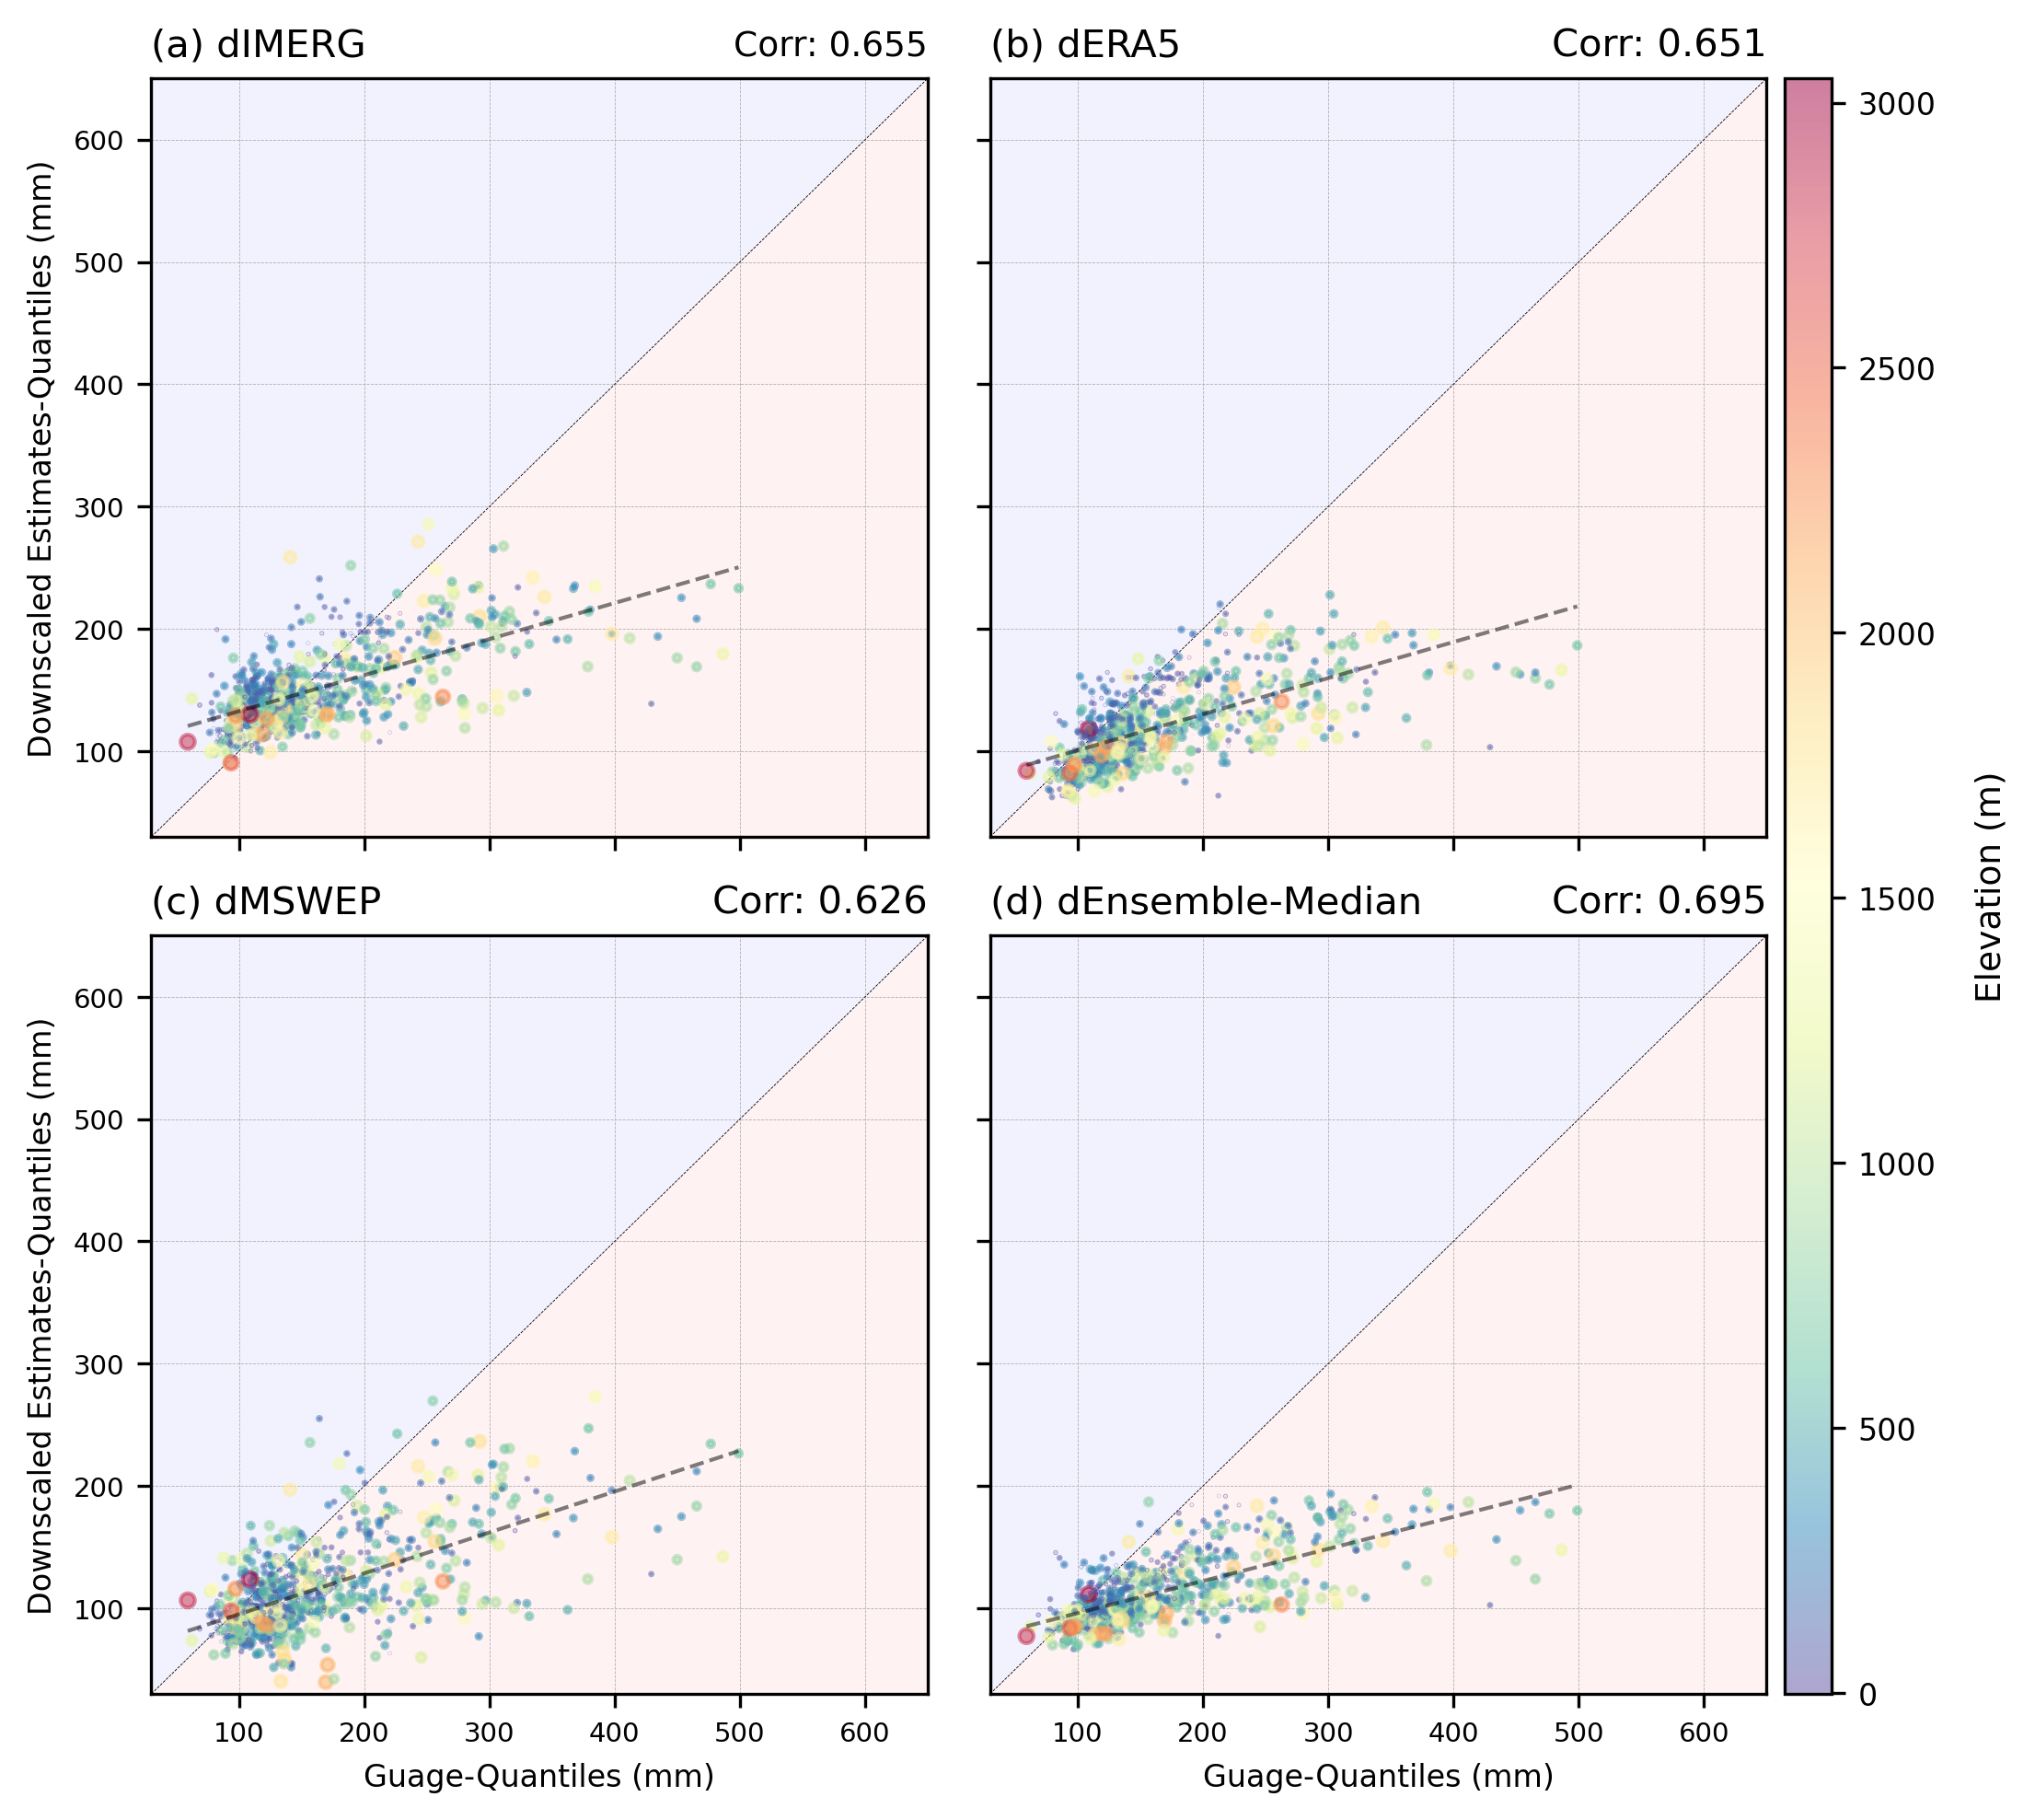

In [21]:
title_fontsize = 10

val_max = 600
vmin = DF_IMERG.ELEV.min()
vmax = DF_IMERG.ELEV.max()

fig = plt.figure(figsize=(6.5,6.5),dpi=300)
gs = gridspec.GridSpec(2, 2)

# ==========================================================================================================
axes = {}
pos = 0
for nrow in range(2):
    for ncol in range(2):
        ax = fig.add_subplot(gs[nrow, ncol])
        ax.grid(linewidth=0.3, linestyle='--')
        ax.set_xlim(30,val_max+50)
        ax.set_ylim(30,val_max+50)
        ax.grid(linestyle='--', linewidth=0.2)
        ax.tick_params(axis='both', which='major', labelsize=7)
        
        ax.plot(np.arange(val_max+50),np.arange(val_max+50),'--k', linewidth=0.2, label='Identity line')
        ax.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
        ax.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

        if ncol > 0:
            ax.set_yticklabels([])
        if nrow == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Guage-Quantiles (mm)',fontsize=8)
        if ncol == 0:
            ax.set_ylabel('Downscaled Estimates-Quantiles (mm)',fontsize=8)

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
        ax.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
        ax.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

        axes[(nrow, ncol)] = ax

# ==========================================================================================================
a1 = axes[(0, 0)].scatter(
    DF_IMERG.OBS, DF_IMERG.DOWN,
    alpha=0.5,
    s=DF_IMERG.ELEVn*15,
    c=DF_IMERG.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 0)].plot(IMERG_x, IMERG_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5,zorder=12)
axes[(0, 0)].set_title('(a) dIMERG', loc='left', fontsize=10)
axes[(0, 0)].set_title(f'Corr: {corr_IMERG}', loc='right', fontsize=9)

# ==========================================================================================================
a2 = axes[(0, 1)].scatter(
    DF_ERA5.OBS, DF_ERA5.DOWN,
    alpha=0.5,
    s=DF_ERA5.ELEVn*15,
    c=DF_ERA5.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 1)].plot(ERA5_x, ERA5_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5,zorder=12)
axes[(0, 1)].set_title('(b) dERA5', loc='left', fontsize=title_fontsize)
axes[(0, 1)].set_title(f'Corr: {corr_ERA5}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 0)].scatter(
    DF_MSWEP.OBS, DF_MSWEP.DOWN,
    alpha=0.5,
    s=DF_MSWEP.ELEVn*15,
    c=DF_MSWEP.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 0)].plot(MSWEP_x, MSWEP_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5,zorder=12)
axes[(1, 0)].set_title('(c) dMSWEP', loc='left', fontsize=title_fontsize)
axes[(1, 0)].set_title(f'Corr: {corr_MSWEP}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 1)].scatter(
    DF_ENSEMBLE_MEDIAN.OBS, DF_ENSEMBLE_MEDIAN.DOWN,
    alpha=0.5,
    s=DF_ENSEMBLE_MEDIAN.ELEVn*15,
    c=DF_ENSEMBLE_MEDIAN.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5,zorder=12)
axes[(1, 1)].set_title('(d) dEnsemble-Median', loc='left', fontsize=title_fontsize)
axes[(1, 1)].set_title(f'Corr: {corr_ENSEMBLE_MEDIAN}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
# ==========================================================================================================
cbar_ax = fig.add_axes([0.96, 0.05, 0.026, 0.9]) #0.96
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Elevation (m)", fontsize=9, labelpad=10) 

# ==========================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.13)

# salida = '../figures/Article_down/Scatter_FOCUS_Validation.png'
# print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

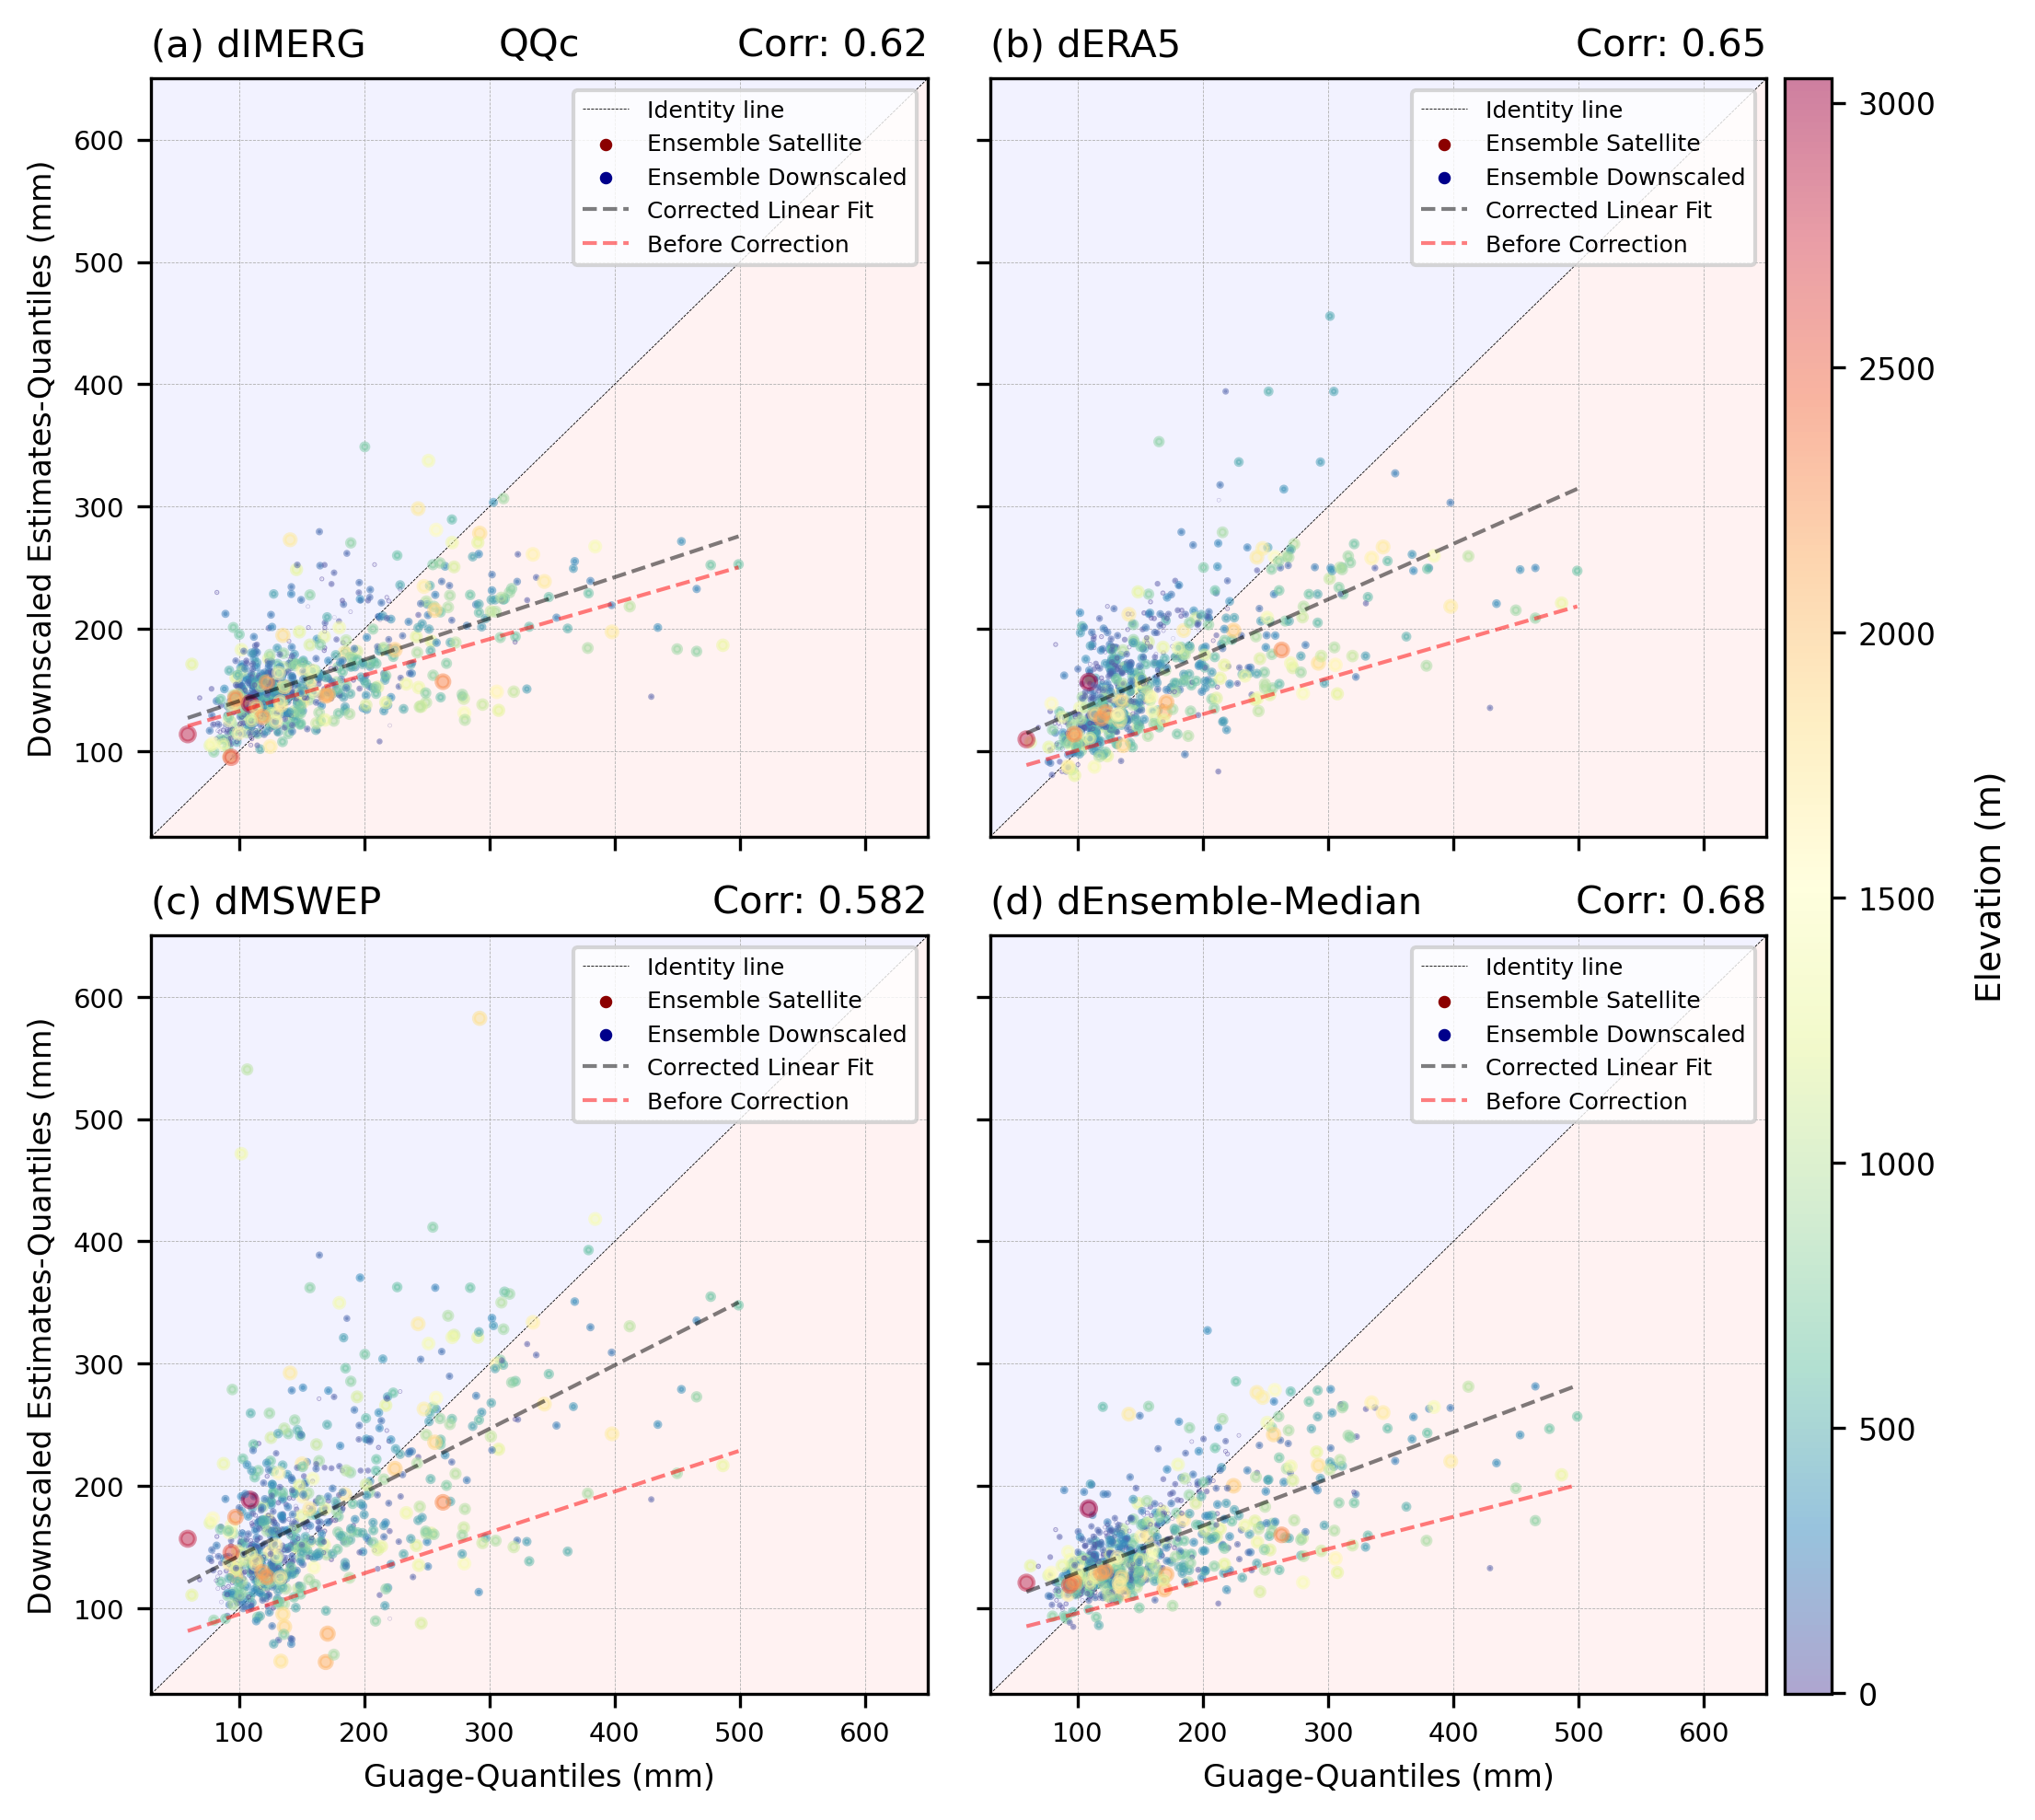

In [41]:
title_fontsize = 10

val_max = 600
vmin = DF_IMERG_QQc.ELEV.min()
vmax = DF_IMERG_QQc.ELEV.max()

fig = plt.figure(figsize=(6.5,6.5),dpi=300)
gs = gridspec.GridSpec(2, 2)

# ==========================================================================================================
axes = {}
pos = 0
for nrow in range(2):
    for ncol in range(2):
        ax = fig.add_subplot(gs[nrow, ncol])
        ax.grid(linewidth=0.3, linestyle='--')
        ax.set_xlim(30,val_max+50)
        ax.set_ylim(30,val_max+50)
        ax.grid(linestyle='--', linewidth=0.2)
        ax.tick_params(axis='both', which='major', labelsize=7)
        
        ax.plot(np.arange(val_max+50),np.arange(val_max+50),'--k', linewidth=0.2, label='Identity line')
        ax.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
        ax.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

        if ncol > 0:
            ax.set_yticklabels([])
        if nrow == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Guage-Quantiles (mm)',fontsize=8)
        if ncol == 0:
            ax.set_ylabel('Downscaled Estimates-Quantiles (mm)',fontsize=8)

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
        ax.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
        ax.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

        axes[(nrow, ncol)] = ax

# ==========================================================================================================
a1 = axes[(0, 0)].scatter(
    DF_IMERG_QQc.OBS, DF_IMERG_QQc.DOWN,
    alpha=0.5,
    s=DF_IMERG_QQc.ELEVn*15,
    c=DF_IMERG_QQc.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 0)].plot(IMERG_QQc_x, IMERG_QQc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 0)].set_title('(a) dIMERG', loc='left', fontsize=title_fontsize)
axes[(0, 0)].set_title(f'QQc', loc='center', fontsize=title_fontsize)
axes[(0, 0)].set_title(f'Corr: {corr_IMERG_QQc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(0, 1)].scatter(
    DF_ERA5_QQc.OBS, DF_ERA5_QQc.DOWN,
    alpha=0.5,
    s=DF_ERA5_QQc.ELEVn*15,
    c=DF_ERA5_QQc.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 1)].plot(ERA5_QQc_x, ERA5_QQc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 1)].set_title('(b) dERA5', loc='left', fontsize=title_fontsize)
axes[(0, 1)].set_title(f'Corr: {corr_ERA5_QQc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 0)].scatter(
    DF_MSWEP_QQc.OBS, DF_MSWEP_QQc.DOWN,
    alpha=0.5,
    s=DF_MSWEP_QQc.ELEVn*15,
    c=DF_MSWEP_QQc.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 0)].plot(MSWEP_QQc_x, MSWEP_QQc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 0)].set_title('(c) dMSWEP', loc='left', fontsize=title_fontsize)
axes[(1, 0)].set_title(f'Corr: {corr_MSWEP_QQc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 1)].scatter(
    DF_ENSEMBLE_MEDIAN_QQc.OBS, DF_ENSEMBLE_MEDIAN_QQc.DOWN,
    alpha=0.5,
    s=DF_ENSEMBLE_MEDIAN_QQc.ELEVn*15,
    c=DF_ENSEMBLE_MEDIAN_QQc.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_QQc_x, ENSEMBLE_MEDIAN_QQc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 1)].set_title('(d) dEnsemble-Median', loc='left', fontsize=title_fontsize)
axes[(1, 1)].set_title(f'Corr: {corr_ENSEMBLE_MEDIAN_QQc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
axes[(0, 0)].plot(IMERG_x, IMERG_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(0, 1)].plot(ERA5_x, ERA5_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(1, 0)].plot(MSWEP_x, MSWEP_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)

axes[(0, 0)].legend(fontsize=6,loc=1)
axes[(0, 1)].legend(fontsize=6,loc=1)
axes[(1, 0)].legend(fontsize=6,loc=1)
axes[(1, 1)].legend(fontsize=6,loc=1)

# ==========================================================================================================
# ==========================================================================================================
cbar_ax = fig.add_axes([0.96, 0.05, 0.026, 0.9]) #0.96
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Elevation (m)", fontsize=9, labelpad=10) 

# ==========================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.13)

# salida = '../figures/Article_down/Scatter_FOCUS_validation_corected_QQc.png'
# print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

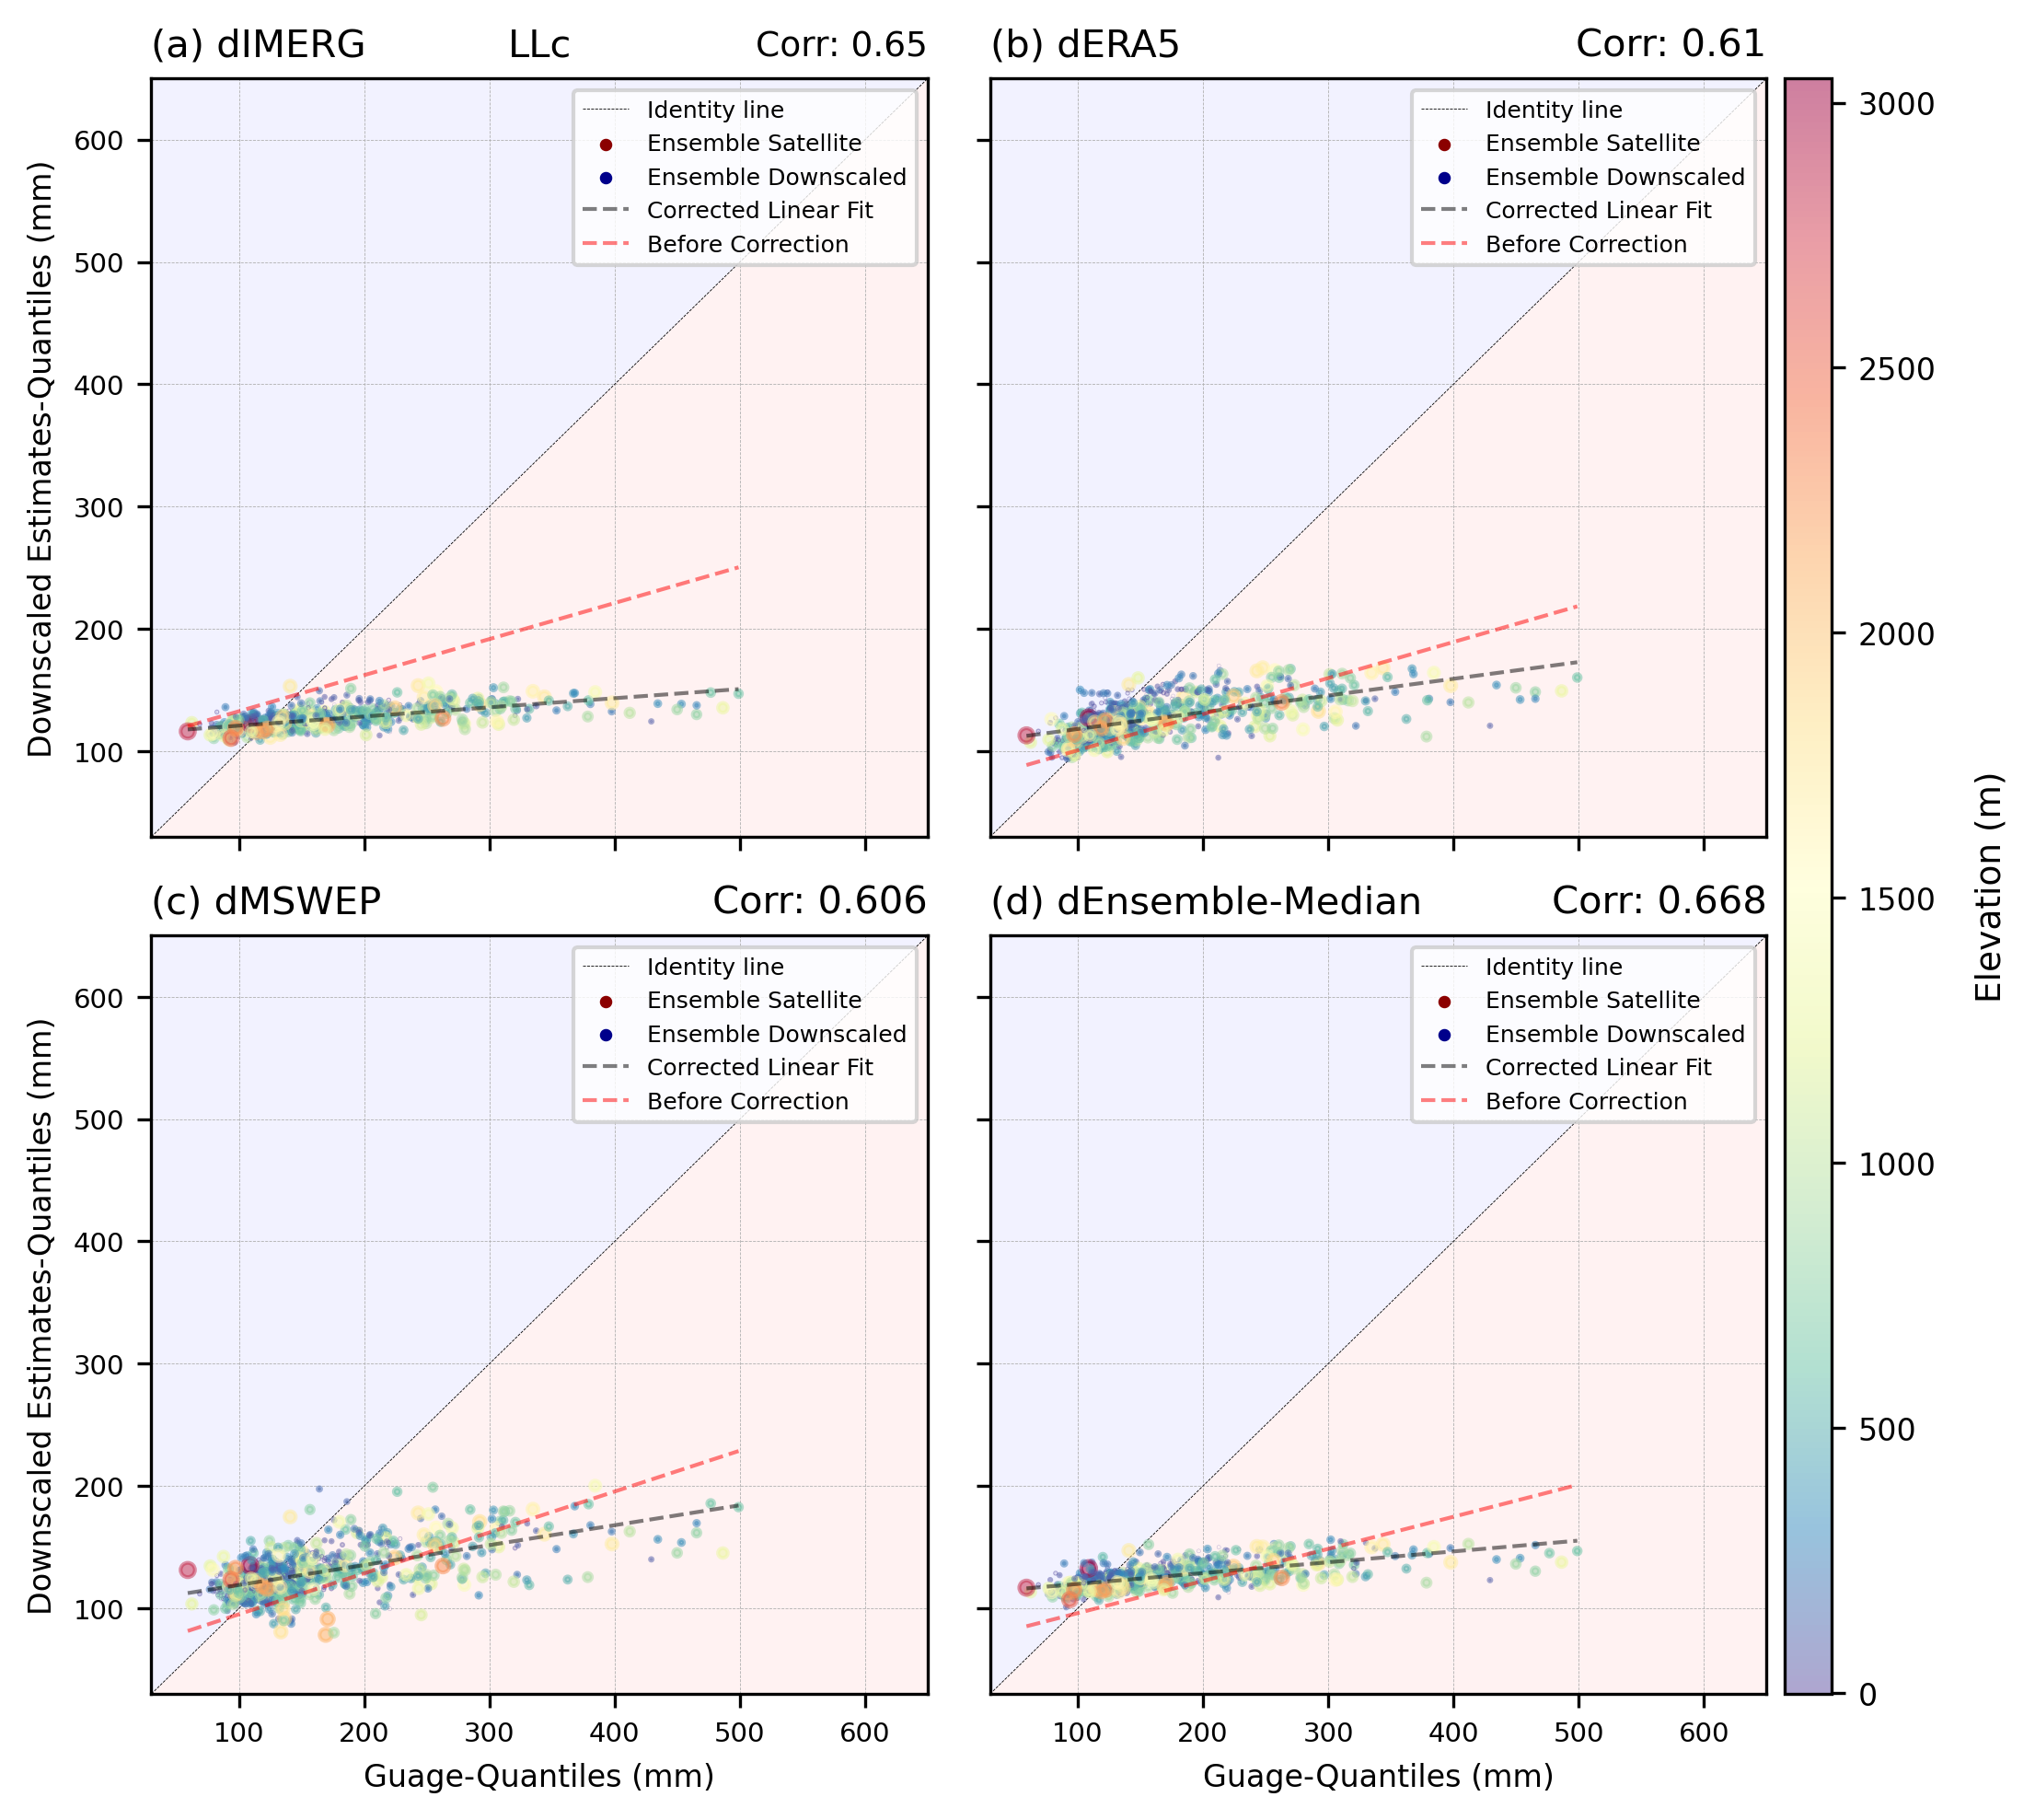

In [42]:
title_fontsize = 10

val_max = 600
vmin = DF_IMERG_LLc.ELEV.min()
vmax = DF_IMERG_LLc.ELEV.max()

fig = plt.figure(figsize=(6.5,6.5),dpi=300)
gs = gridspec.GridSpec(2, 2)

# ==========================================================================================================
axes = {}
pos = 0
for nrow in range(2):
    for ncol in range(2):
        ax = fig.add_subplot(gs[nrow, ncol])
        ax.grid(linewidth=0.3, linestyle='--')
        ax.set_xlim(30,val_max+50)
        ax.set_ylim(30,val_max+50)
        ax.grid(linestyle='--', linewidth=0.2)
        ax.tick_params(axis='both', which='major', labelsize=7)
        
        ax.plot(np.arange(val_max+50),np.arange(val_max+50),'--k', linewidth=0.2, label='Identity line')
        ax.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
        ax.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

        if ncol > 0:
            ax.set_yticklabels([])
        if nrow == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Guage-Quantiles (mm)',fontsize=8)
        if ncol == 0:
            ax.set_ylabel('Downscaled Estimates-Quantiles (mm)',fontsize=8)

        # xlim = ax.get_xlim()
        # ylim = ax.get_ylim()

        # xlim = ax.get_xlim()
        # ylim = ax.get_ylim()
        x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
        ax.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
        ax.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

        axes[(nrow, ncol)] = ax

# ==========================================================================================================
a1 = axes[(0, 0)].scatter(
    DF_IMERG_LLc.OBS, DF_IMERG_LLc.DOWN,
    alpha=0.5,
    s=DF_IMERG_LLc.ELEVn*15,
    c=DF_IMERG_LLc.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 0)].plot(IMERG_LLc_x, IMERG_LLc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 0)].set_title('(a) dIMERG', loc='left', fontsize=10)
axes[(0, 0)].set_title(f'LLc', loc='center', fontsize=title_fontsize)
axes[(0, 0)].set_title(f'Corr: {corr_IMERG_LLc}', loc='right', fontsize=9)

# ==========================================================================================================
a2 = axes[(0, 1)].scatter(
    DF_ERA5_LLc.OBS, DF_ERA5_LLc.DOWN,
    alpha=0.5,
    s=DF_ERA5_LLc.ELEVn*15,
    c=DF_ERA5_LLc.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 1)].plot(ERA5_LLc_x, ERA5_LLc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 1)].set_title('(b) dERA5', loc='left', fontsize=title_fontsize)
axes[(0, 1)].set_title(f'Corr: {corr_ERA5_LLc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 0)].scatter(
    DF_MSWEP_LLc.OBS, DF_MSWEP_LLc.DOWN,
    alpha=0.5,
    s=DF_MSWEP_LLc.ELEVn*15,
    c=DF_MSWEP_LLc.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 0)].plot(MSWEP_LLc_x, MSWEP_LLc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 0)].set_title('(c) dMSWEP', loc='left', fontsize=title_fontsize)
axes[(1, 0)].set_title(f'Corr: {corr_MSWEP_LLc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 1)].scatter(
    DF_ENSEMBLE_MEDIAN_LLc.OBS, DF_ENSEMBLE_MEDIAN_LLc.DOWN,
    alpha=0.5,
    s=DF_ENSEMBLE_MEDIAN_LLc.ELEVn*15,
    c=DF_ENSEMBLE_MEDIAN_LLc.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_LLc_x, ENSEMBLE_MEDIAN_LLc_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 1)].set_title('(d) dEnsemble-Median', loc='left', fontsize=title_fontsize)
axes[(1, 1)].set_title(f'Corr: {corr_ENSEMBLE_MEDIAN_LLc}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
axes[(0, 0)].plot(IMERG_x, IMERG_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(0, 1)].plot(ERA5_x, ERA5_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(1, 0)].plot(MSWEP_x, MSWEP_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)

axes[(0, 0)].legend(fontsize=6,loc=1)
axes[(0, 1)].legend(fontsize=6,loc=1)
axes[(1, 0)].legend(fontsize=6,loc=1)
axes[(1, 1)].legend(fontsize=6,loc=1)

# ==========================================================================================================
# ==========================================================================================================
cbar_ax = fig.add_axes([0.96, 0.05, 0.026, 0.9]) #0.96
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Elevation (m)", fontsize=9, labelpad=10) 

# ==========================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.13)

# salida = '../figures/Article_down/Scatter_FOCUS_validation_corected_LLc.png'
# print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

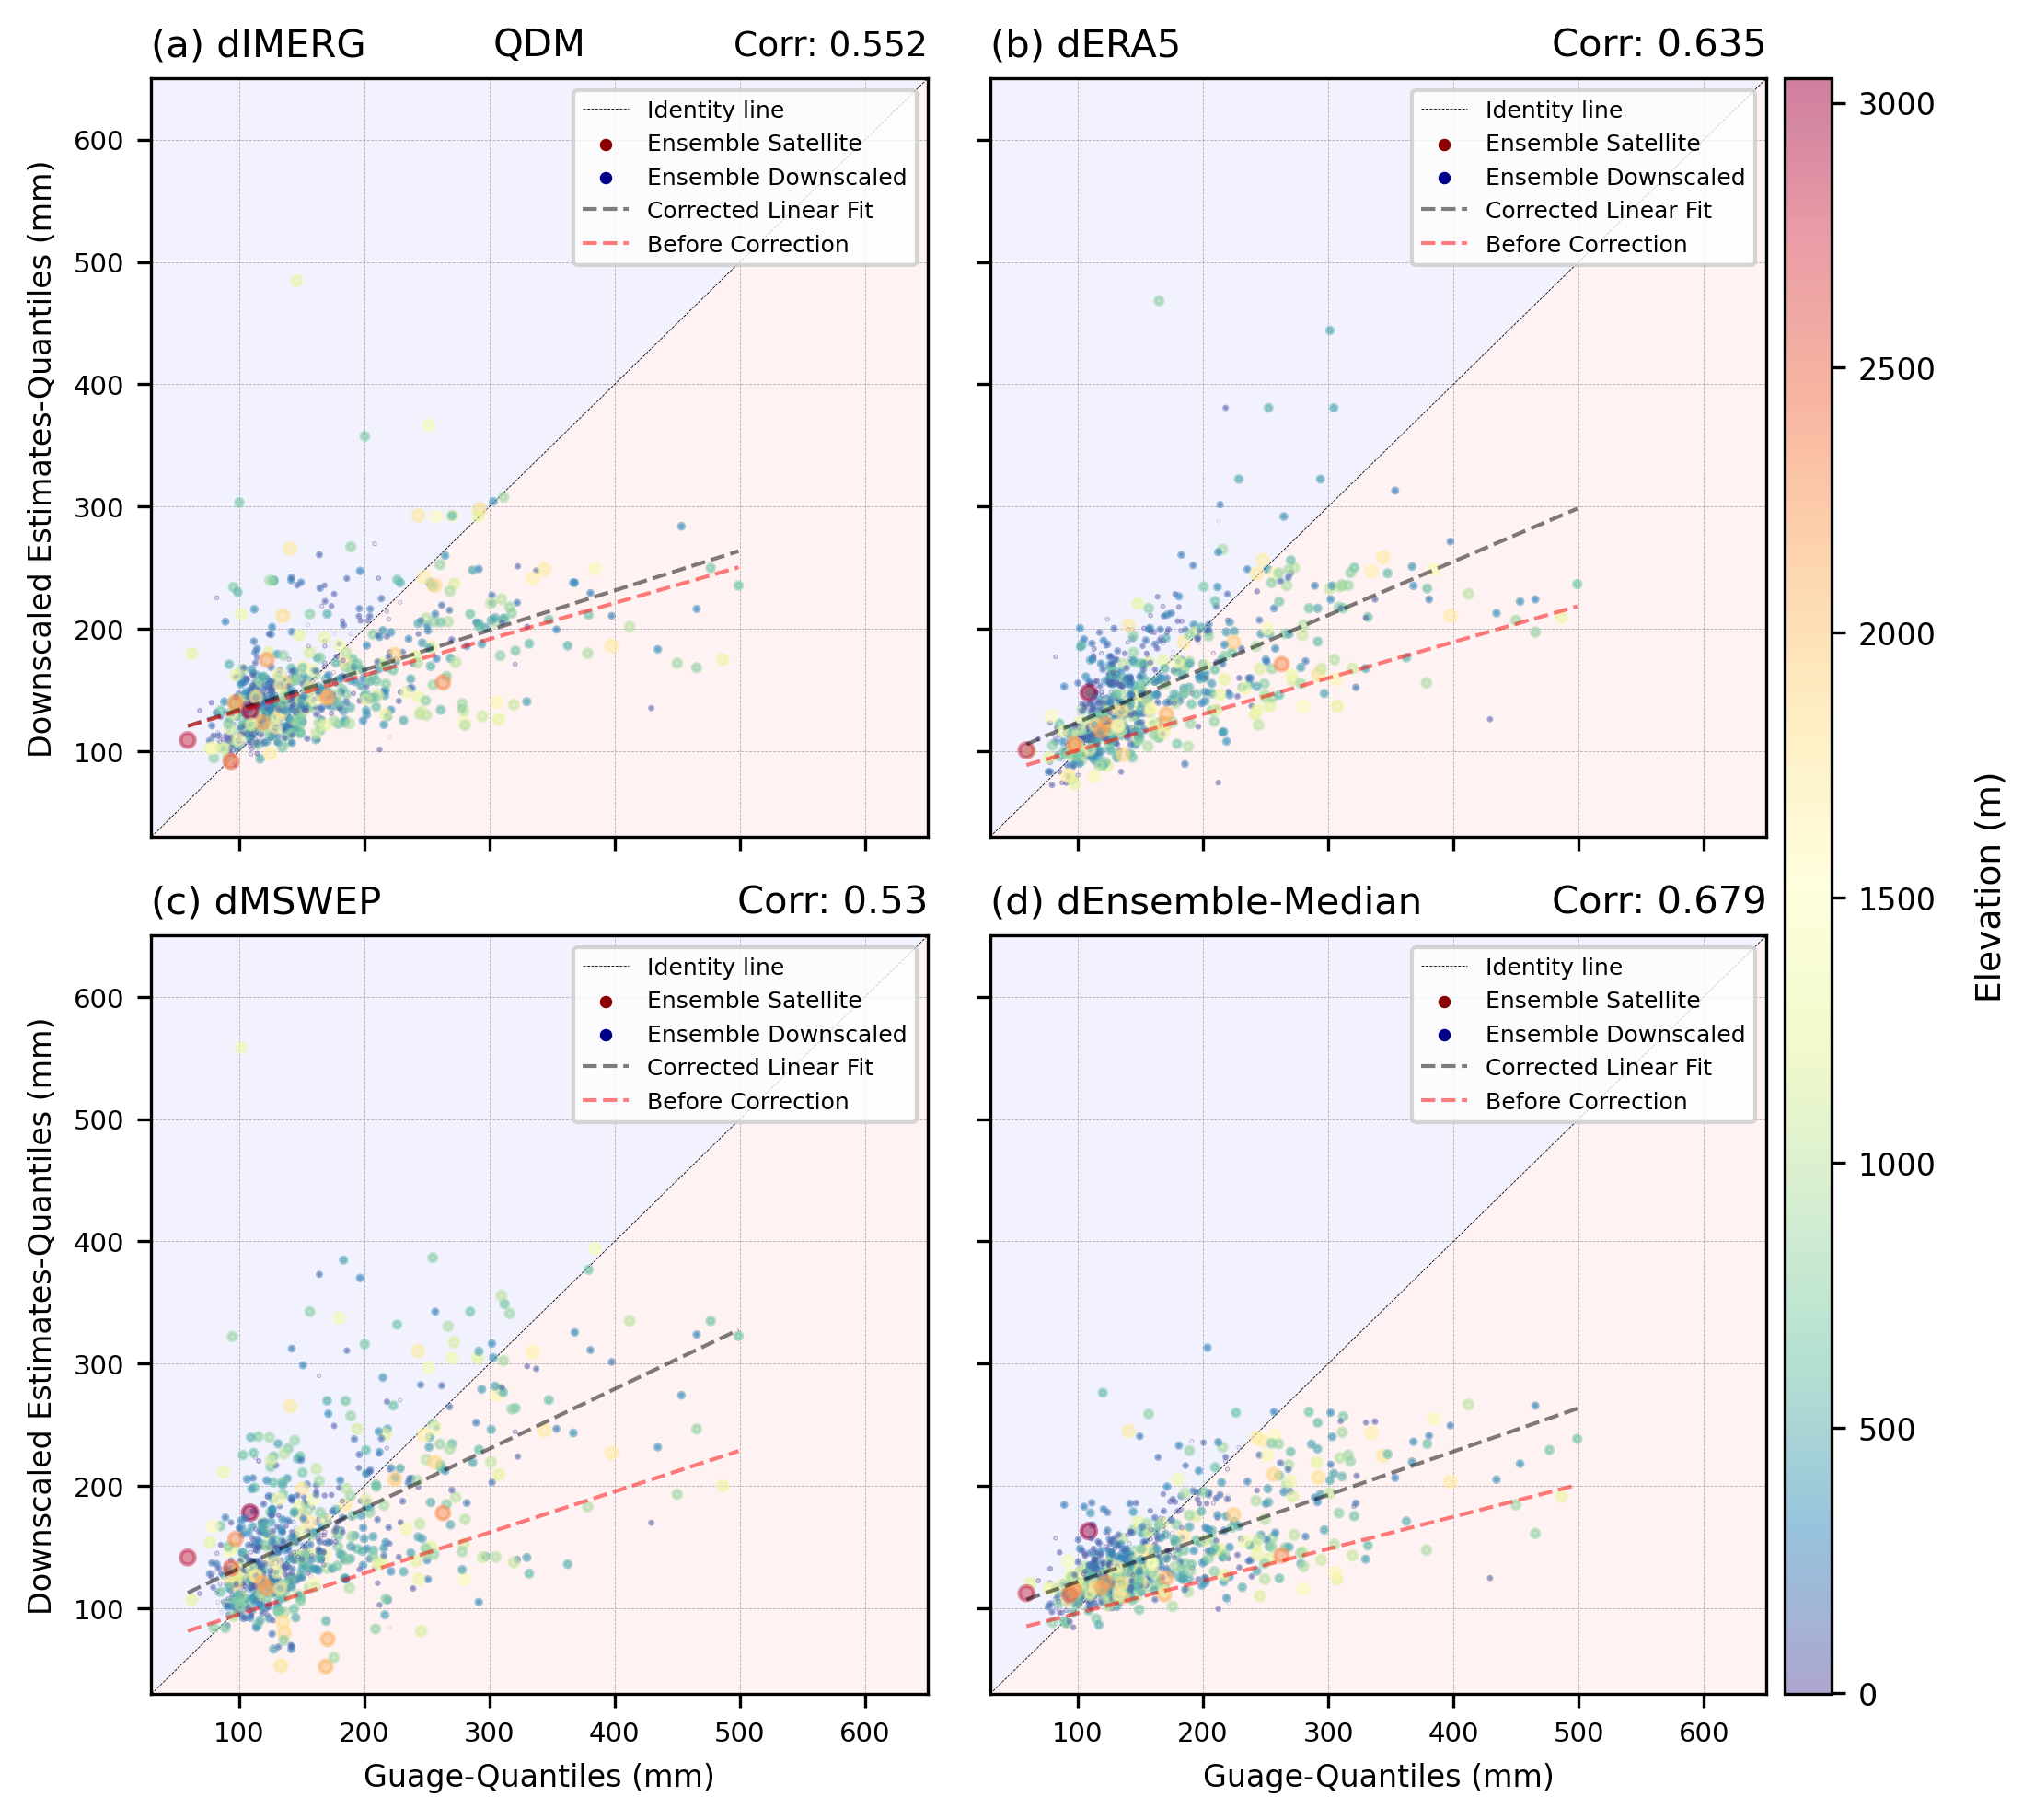

In [43]:
title_fontsize = 10

val_max = 600
vmin = DF_IMERG_QDM.ELEV.min()
vmax = DF_IMERG_QDM.ELEV.max()

fig = plt.figure(figsize=(6.5,6.5),dpi=300)
gs = gridspec.GridSpec(2, 2)

# ==========================================================================================================
axes = {}
pos = 0
for nrow in range(2):
    for ncol in range(2):
        ax = fig.add_subplot(gs[nrow, ncol])
        ax.grid(linewidth=0.3, linestyle='--')
        ax.set_xlim(30,val_max+50)
        ax.set_ylim(30,val_max+50)
        ax.grid(linestyle='--', linewidth=0.2)
        ax.tick_params(axis='both', which='major', labelsize=7)
        
        ax.plot(np.arange(val_max+50),np.arange(val_max+50),'--k', linewidth=0.2, label='Identity line')
        ax.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
        ax.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

        if ncol > 0:
            ax.set_yticklabels([])
        if nrow == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Guage-Quantiles (mm)',fontsize=8)
        if ncol == 0:
            ax.set_ylabel('Downscaled Estimates-Quantiles (mm)',fontsize=8)

        # xlim = ax.get_xlim()
        # ylim = ax.get_ylim()

        # xlim = ax.get_xlim()
        # ylim = ax.get_ylim()
        x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
        ax.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
        ax.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

        axes[(nrow, ncol)] = ax

# ==========================================================================================================
a1 = axes[(0, 0)].scatter(
    DF_IMERG_QDM.OBS, DF_IMERG_QDM.DOWN,
    alpha=0.5,
    s=DF_IMERG_QDM.ELEVn*15,
    c=DF_IMERG_QDM.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 0)].plot(IMERG_QDM_x, IMERG_QDM_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 0)].set_title('(a) dIMERG', loc='left', fontsize=10)
axes[(0, 0)].set_title(f'QDM', loc='center', fontsize=title_fontsize)
axes[(0, 0)].set_title(f'Corr: {corr_IMERG_QDM}', loc='right', fontsize=9)

# ==========================================================================================================
a2 = axes[(0, 1)].scatter(
    DF_ERA5_QDM.OBS, DF_ERA5_QDM.DOWN,
    alpha=0.5,
    s=DF_ERA5_QDM.ELEVn*15,
    c=DF_ERA5_QDM.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 1)].plot(ERA5_QDM_x, ERA5_QDM_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 1)].set_title('(b) dERA5', loc='left', fontsize=title_fontsize)
axes[(0, 1)].set_title(f'Corr: {corr_ERA5_QDM}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 0)].scatter(
    DF_MSWEP_QDM.OBS, DF_MSWEP_QDM.DOWN,
    alpha=0.5,
    s=DF_MSWEP_QDM.ELEVn*15,
    c=DF_MSWEP_QDM.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 0)].plot(MSWEP_QDM_x, MSWEP_QDM_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 0)].set_title('(c) dMSWEP', loc='left', fontsize=title_fontsize)
axes[(1, 0)].set_title(f'Corr: {corr_MSWEP_QDM}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 1)].scatter(
    DF_ENSEMBLE_MEDIAN_QDM.OBS, DF_ENSEMBLE_MEDIAN_QDM.DOWN,
    alpha=0.5,
    s=DF_ENSEMBLE_MEDIAN_QDM.ELEVn*15,
    c=DF_ENSEMBLE_MEDIAN_QDM.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_QDM_x, ENSEMBLE_MEDIAN_QDM_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 1)].set_title('(d) dEnsemble-Median', loc='left', fontsize=title_fontsize)
axes[(1, 1)].set_title(f'Corr: {corr_ENSEMBLE_MEDIAN_QDM}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
axes[(0, 0)].plot(IMERG_x, IMERG_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(0, 1)].plot(ERA5_x, ERA5_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(1, 0)].plot(MSWEP_x, MSWEP_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)

axes[(0, 0)].legend(fontsize=6,loc=1)
axes[(0, 1)].legend(fontsize=6,loc=1)
axes[(1, 0)].legend(fontsize=6,loc=1)
axes[(1, 1)].legend(fontsize=6,loc=1)

# ==========================================================================================================
# ==========================================================================================================
cbar_ax = fig.add_axes([0.96, 0.05, 0.026, 0.9]) #0.96
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Elevation (m)", fontsize=9, labelpad=10) 

# ==========================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.13)

# salida = '../figures/Article_down/Scatter_FOCUS_validation_corected_QDM.png'
# print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

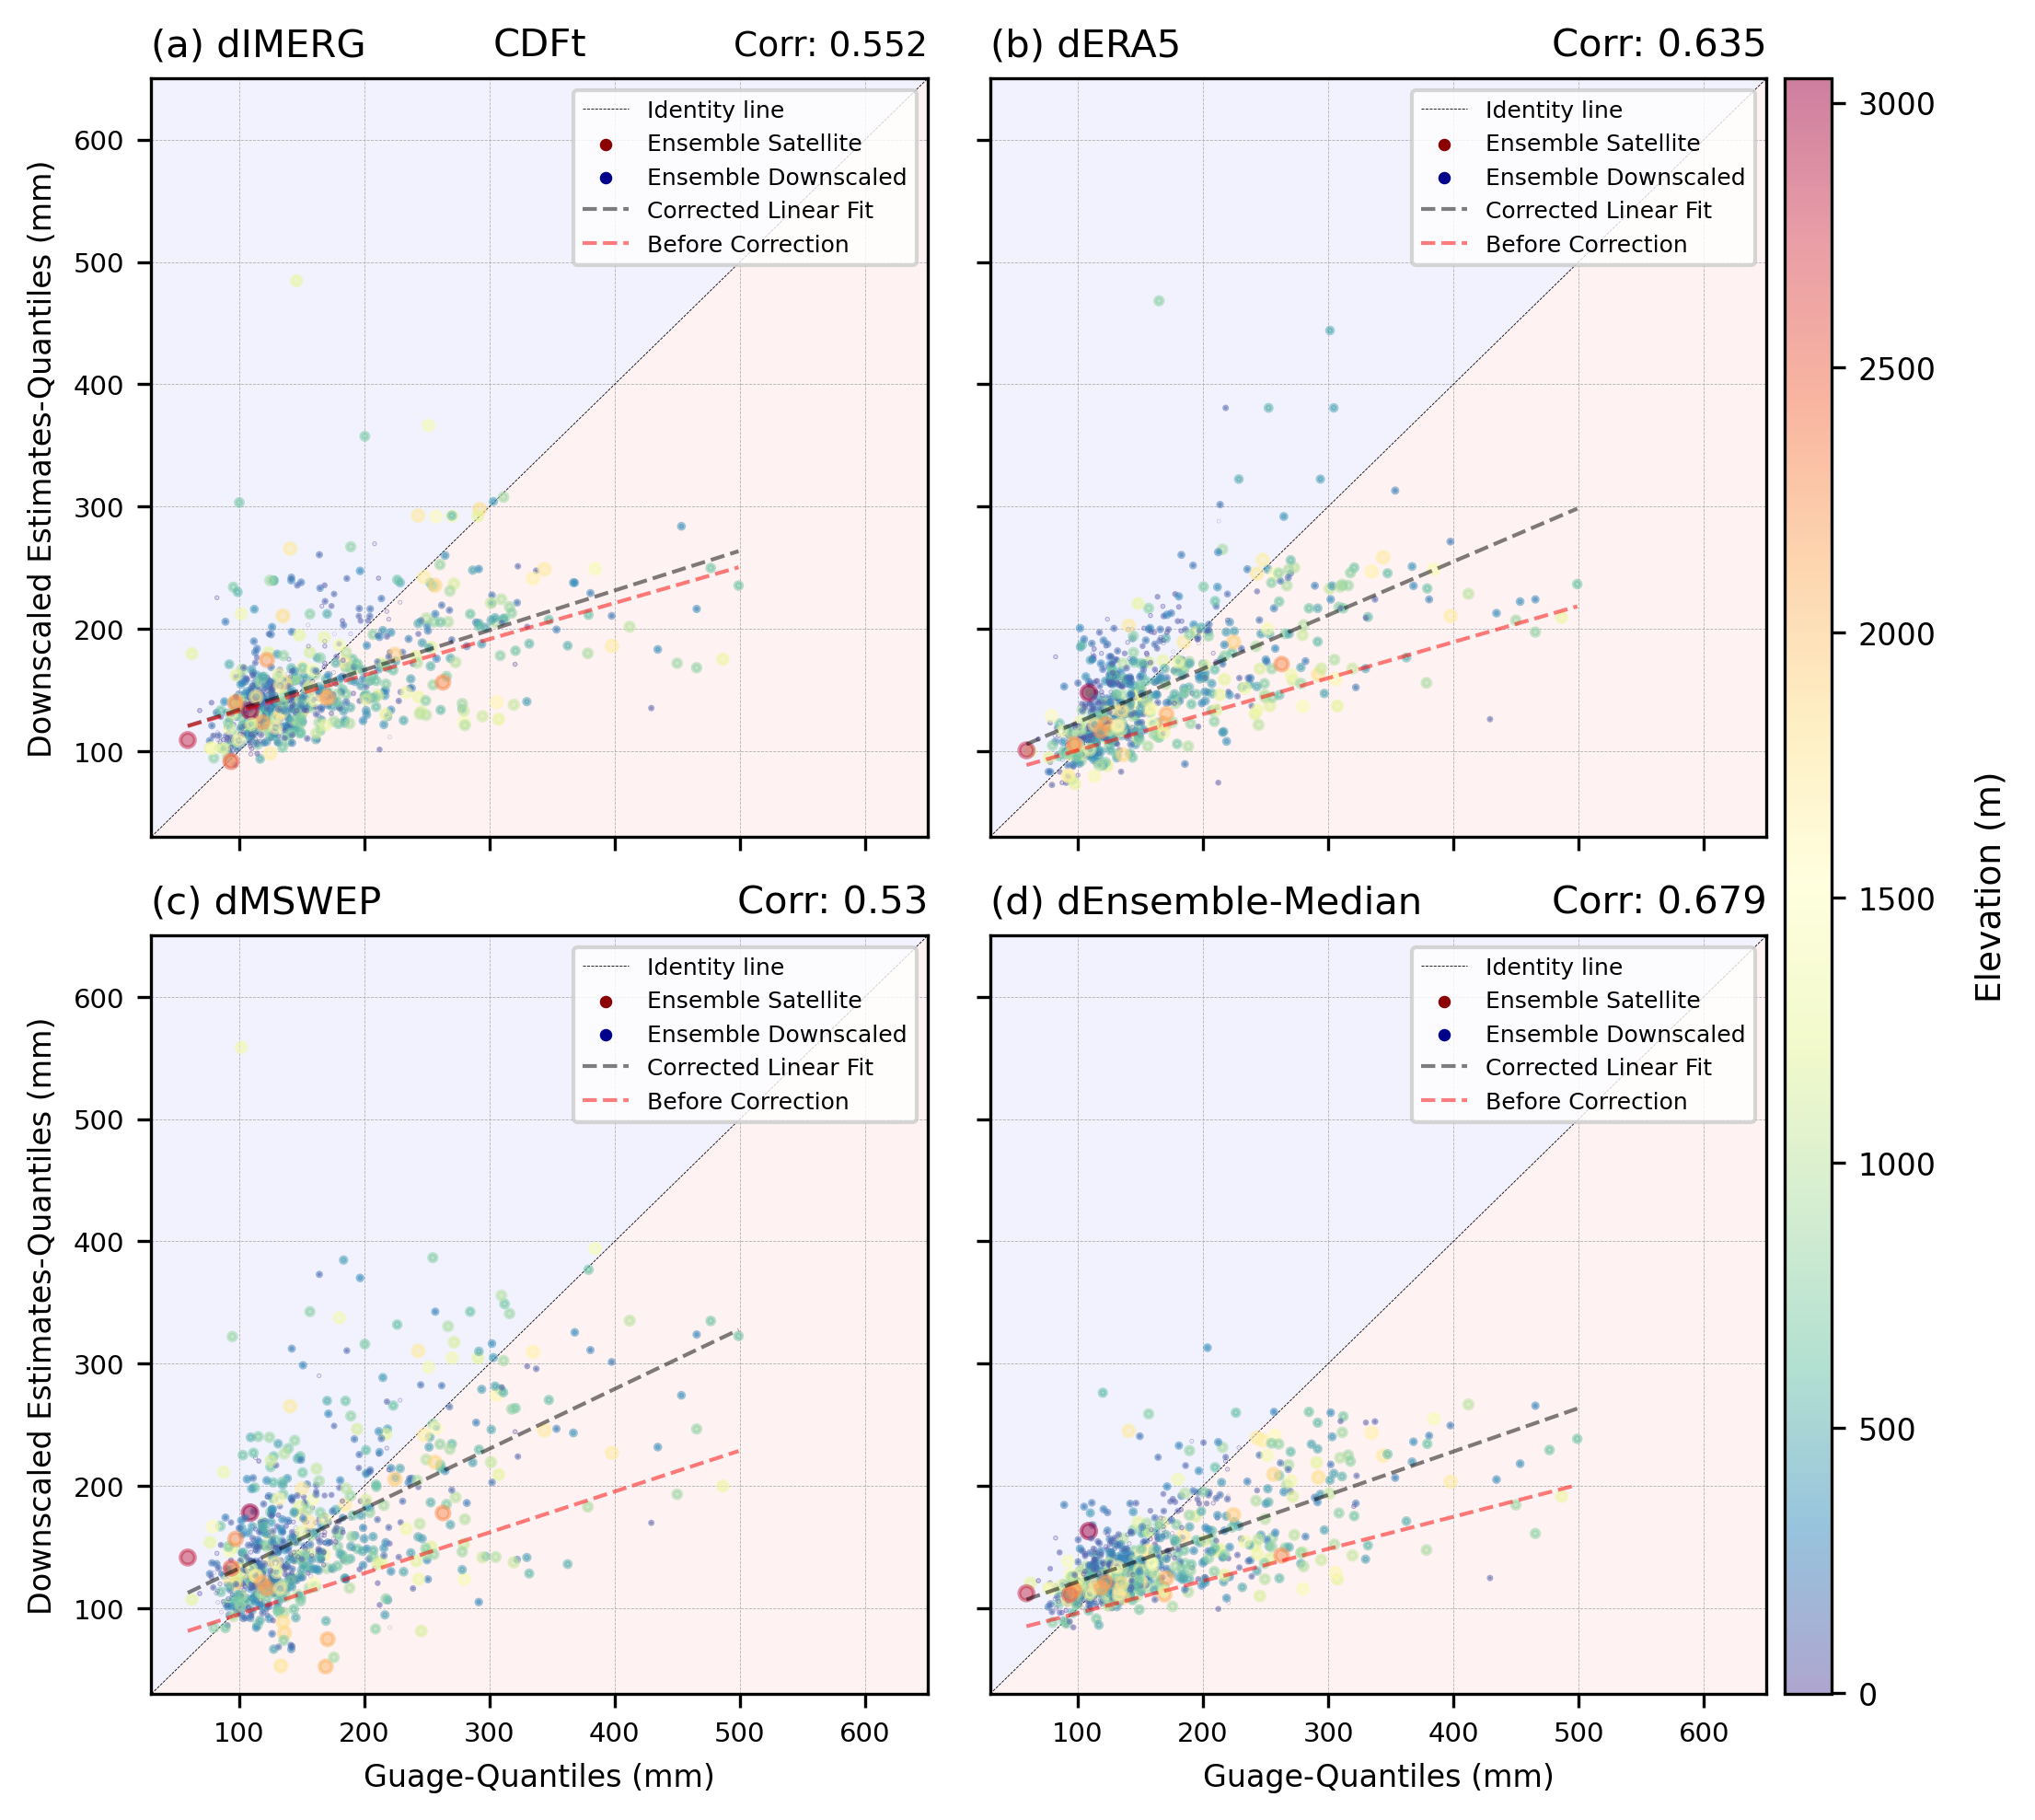

In [44]:
title_fontsize = 10

val_max = 600
vmin = DF_IMERG_CDFt.ELEV.min()
vmax = DF_IMERG_CDFt.ELEV.max()

fig = plt.figure(figsize=(6.5,6.5),dpi=300)
gs = gridspec.GridSpec(2, 2)

# ==========================================================================================================
axes = {}
pos = 0
for nrow in range(2):
    for ncol in range(2):
        ax = fig.add_subplot(gs[nrow, ncol])
        ax.grid(linewidth=0.3, linestyle='--')
        ax.set_xlim(30,val_max+50)
        ax.set_ylim(30,val_max+50)
        ax.grid(linestyle='--', linewidth=0.2)
        ax.tick_params(axis='both', which='major', labelsize=7)
        
        ax.plot(np.arange(val_max+50),np.arange(val_max+50),'--k', linewidth=0.2, label='Identity line')
        ax.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
        ax.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

        if ncol > 0:
            ax.set_yticklabels([])
        if nrow == 0:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('Guage-Quantiles (mm)',fontsize=8)
        if ncol == 0:
            ax.set_ylabel('Downscaled Estimates-Quantiles (mm)',fontsize=8)

        # xlim = ax.get_xlim()
        # ylim = ax.get_ylim()

        # xlim = ax.get_xlim()
        # ylim = ax.get_ylim()
        x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
        ax.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
        ax.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

        axes[(nrow, ncol)] = ax

# ==========================================================================================================
a1 = axes[(0, 0)].scatter(
    DF_IMERG_CDFt.OBS, DF_IMERG_CDFt.DOWN,
    alpha=0.5,
    s=DF_IMERG_CDFt.ELEVn*15,
    c=DF_IMERG_CDFt.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 0)].plot(IMERG_CDFt_x, IMERG_CDFt_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 0)].set_title('(a) dIMERG', loc='left', fontsize=10)
axes[(0, 0)].set_title(f'CDFt', loc='center', fontsize=title_fontsize)
axes[(0, 0)].set_title(f'Corr: {corr_IMERG_CDFt}', loc='right', fontsize=9)

# ==========================================================================================================
a2 = axes[(0, 1)].scatter(
    DF_ERA5_CDFt.OBS, DF_ERA5_CDFt.DOWN,
    alpha=0.5,
    s=DF_ERA5_CDFt.ELEVn*15,
    c=DF_ERA5_CDFt.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(0, 1)].plot(ERA5_CDFt_x, ERA5_CDFt_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(0, 1)].set_title('(b) dERA5', loc='left', fontsize=title_fontsize)
axes[(0, 1)].set_title(f'Corr: {corr_ERA5_CDFt}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 0)].scatter(
    DF_MSWEP_CDFt.OBS, DF_MSWEP_CDFt.DOWN,
    alpha=0.5,
    s=DF_MSWEP_CDFt.ELEVn*15,
    c=DF_MSWEP_CDFt.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 0)].plot(MSWEP_CDFt_x, MSWEP_CDFt_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 0)].set_title('(c) dMSWEP', loc='left', fontsize=title_fontsize)
axes[(1, 0)].set_title(f'Corr: {corr_MSWEP_CDFt}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
a2 = axes[(1, 1)].scatter(
    DF_ENSEMBLE_MEDIAN_CDFt.OBS, DF_ENSEMBLE_MEDIAN_CDFt.DOWN,
    alpha=0.5,
    s=DF_ENSEMBLE_MEDIAN_CDFt.ELEVn*15,
    c=DF_ENSEMBLE_MEDIAN_CDFt.ELEV,
    vmin=vmin, vmax=vmax,
    zorder=10, cmap="Spectral_r")
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_CDFt_x, ENSEMBLE_MEDIAN_CDFt_y, "--k", linewidth=1, label="Corrected Linear Fit", alpha=0.5,zorder=12)
axes[(1, 1)].set_title('(d) dEnsemble-Median', loc='left', fontsize=title_fontsize)
axes[(1, 1)].set_title(f'Corr: {corr_ENSEMBLE_MEDIAN_CDFt}', loc='right', fontsize=title_fontsize)

# ==========================================================================================================
axes[(0, 0)].plot(IMERG_x, IMERG_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(0, 1)].plot(ERA5_x, ERA5_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(1, 0)].plot(MSWEP_x, MSWEP_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)
axes[(1, 1)].plot(ENSEMBLE_MEDIAN_x, ENSEMBLE_MEDIAN_y, "--r", linewidth=1, label="Before Correction", alpha=0.5,zorder=12)

axes[(0, 0)].legend(fontsize=6,loc=1)
axes[(0, 1)].legend(fontsize=6,loc=1)
axes[(1, 0)].legend(fontsize=6,loc=1)
axes[(1, 1)].legend(fontsize=6,loc=1)

# ==========================================================================================================
# ==========================================================================================================
cbar_ax = fig.add_axes([0.96, 0.05, 0.026, 0.9]) #0.96
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Elevation (m)", fontsize=9, labelpad=10) 

# ==========================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.13)

# salida = '../figures/Article_down/Scatter_FOCUS_validation_corected_CDFt.png'
# print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [26]:
datasets_keep = ['IMERG', 'ERA5', 'MSWEP', 'ENSEMBLE MEDIAN']

RSR_DOWN_compare_filter = RSR_DOWN_compare[RSR_DOWN_compare['Dataset'].isin(datasets_keep)].reset_index(drop=True)
RSR_DOWN_compare_filter['Dataset'] = RSR_DOWN_compare_filter['Dataset'].replace('IMERG','dIMERG')
RSR_DOWN_compare_filter['Dataset'] = RSR_DOWN_compare_filter['Dataset'].replace('MSWEP','dMSWEP')
RSR_DOWN_compare_filter['Dataset'] = RSR_DOWN_compare_filter['Dataset'].replace('ERA5','dERA5')
RSR_DOWN_compare_filter['Dataset'] = RSR_DOWN_compare_filter['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median')

RSR_DOWN_compare_QQc_filter = (RSR_DOWN_compare_QQc[RSR_DOWN_compare_QQc['Dataset'].isin(datasets_keep)].reset_index(drop=True))
RSR_DOWN_compare_QQc_filter['Dataset'] = RSR_DOWN_compare_QQc_filter['Dataset'].replace('IMERG','dIMERG QQc')
RSR_DOWN_compare_QQc_filter['Dataset'] = RSR_DOWN_compare_QQc_filter['Dataset'].replace('MSWEP','dMSWEP QQc')
RSR_DOWN_compare_QQc_filter['Dataset'] = RSR_DOWN_compare_QQc_filter['Dataset'].replace('ERA5','dERA5 QQc')
RSR_DOWN_compare_QQc_filter['Dataset'] = RSR_DOWN_compare_QQc_filter['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median QQc')

RSR_DOWN_compare_LLc_filter = (RSR_DOWN_compare_LLc[RSR_DOWN_compare_LLc['Dataset'].isin(datasets_keep)].reset_index(drop=True))
RSR_DOWN_compare_LLc_filter['Dataset'] = RSR_DOWN_compare_LLc_filter['Dataset'].replace('IMERG','dIMERG LLc')
RSR_DOWN_compare_LLc_filter['Dataset'] = RSR_DOWN_compare_LLc_filter['Dataset'].replace('MSWEP','dMSWEP LLc')
RSR_DOWN_compare_LLc_filter['Dataset'] = RSR_DOWN_compare_LLc_filter['Dataset'].replace('ERA5','dERA5 LLc')
RSR_DOWN_compare_LLc_filter['Dataset'] = RSR_DOWN_compare_LLc_filter['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median LLc')

RSR_DOWN_compare_QDM_filter = (RSR_DOWN_compare_QDM[RSR_DOWN_compare_QDM['Dataset'].isin(datasets_keep)].reset_index(drop=True))
RSR_DOWN_compare_QDM_filter['Dataset'] = RSR_DOWN_compare_QDM_filter['Dataset'].replace('IMERG','dIMERG QDM')
RSR_DOWN_compare_QDM_filter['Dataset'] = RSR_DOWN_compare_QDM_filter['Dataset'].replace('MSWEP','dMSWEP QDM')
RSR_DOWN_compare_QDM_filter['Dataset'] = RSR_DOWN_compare_QDM_filter['Dataset'].replace('ERA5','dERA5 QDM')
RSR_DOWN_compare_QDM_filter['Dataset'] = RSR_DOWN_compare_QDM_filter['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median QDM')

# Same than QDM
# RSR_DOWN_compare_CDFt_filter = (RSR_DOWN_compare_CDFt[RSR_DOWN_compare_CDFt['Dataset'].isin(datasets_keep)].reset_index(drop=True))
# RSR_DOWN_compare_CDFt_filter['Dataset'] = RSR_DOWN_compare_CDFt_filter['Dataset'].replace('IMERG','dIMERG LRc')
# RSR_DOWN_compare_CDFt_filter['Dataset'] = RSR_DOWN_compare_CDFt_filter['Dataset'].replace('MSWEP','dMSWEP LRc')
# RSR_DOWN_compare_CDFt_filter['Dataset'] = RSR_DOWN_compare_CDFt_filter['Dataset'].replace('ERA5','dERA5 LRc')
# RSR_DOWN_compare_CDFt_filter['Dataset'] = RSR_DOWN_compare_CDFt_filter['Dataset'].replace('ENSEMBLE MEDIAN','dEnsemble-Median LRc')

In [27]:
RSR_OBS_QQc = pd.concat(
    [RSR_DOWN_compare_filter, RSR_DOWN_compare_QQc_filter],
    axis=0,
    ignore_index=True
)

RSR_OBS_LLc = pd.concat(
    [RSR_DOWN_compare_filter, RSR_DOWN_compare_LLc_filter],
    axis=0,
    ignore_index=True
)

RSR_OBS_QDM = pd.concat(
    [RSR_DOWN_compare_filter, RSR_DOWN_compare_QDM_filter],
    axis=0,
    ignore_index=True
)

colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange', 'cyan']

In [28]:
RSR_QQc_LRc = pd.concat(
    [RSR_DOWN_compare_filter, RSR_DOWN_compare_QQc_filter, RSR_DOWN_compare_LLc_filter, RSR_DOWN_compare_QDM_filter],
    axis=0,
    ignore_index=True
)

colors_T = [colors[0], colors[2], colors[3], 'k', 
            colors[0], colors[2], colors[3], 'k', 
            colors[0], colors[2], colors[3], 'k',
            colors[0], colors[2], colors[3], 'k']

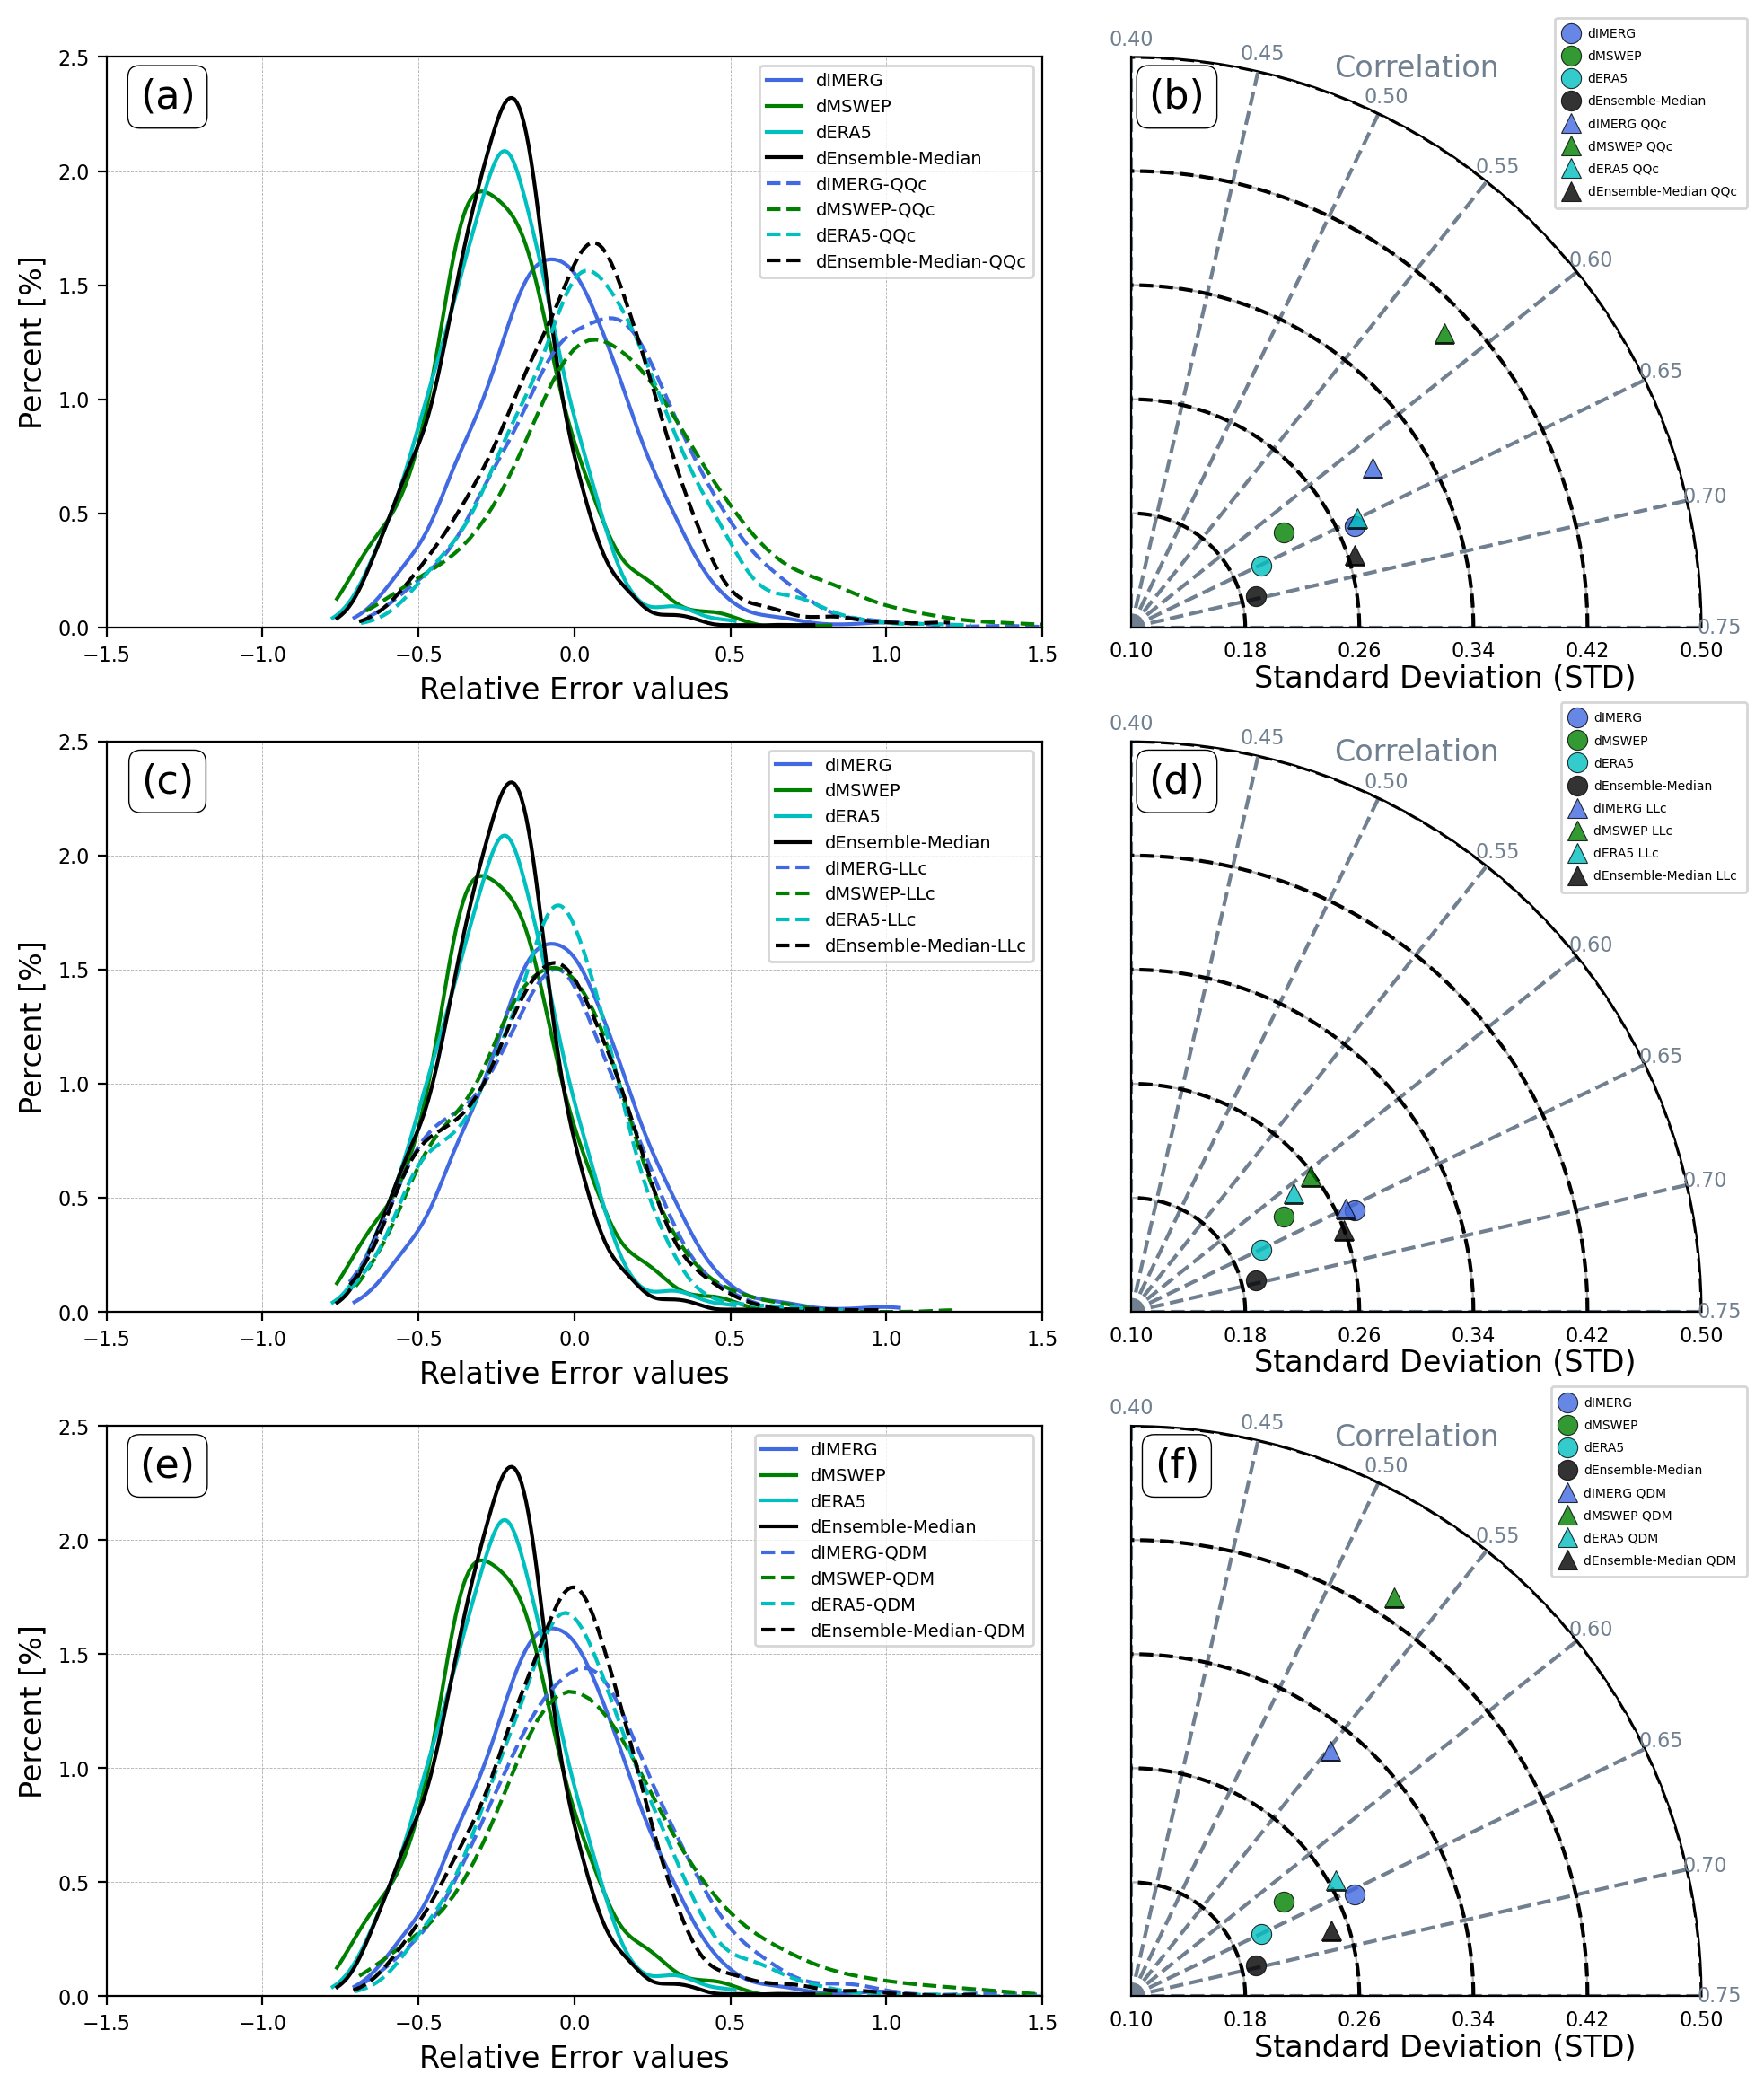

In [29]:
markers_T = ['o', 'o', 'o', 'o', '^', '^', '^', '^']
fig = plt.figure(figsize=(11,12),dpi=200)
gs = gridspec.GridSpec(3,2)

# =====================================================================================================================================================
# =====================================================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(DF_IMERG.RER,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_IMERG.RER)), np.nanmax(np.array(DF_IMERG.RER))))
sns.kdeplot(DF_MSWEP.RER,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_MSWEP.RER)), np.nanmax(np.array(DF_MSWEP.RER))))
sns.kdeplot(DF_ERA5.RER,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_ERA5.RER)), np.nanmax(np.array(DF_ERA5.RER))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RED,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RED))))

sns.kdeplot(DF_IMERG_QQc.RED,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-QQc',
            clip=(np.nanmin(np.array(DF_IMERG_QQc.RED)), np.nanmax(np.array(DF_IMERG_QQc.RED))))
sns.kdeplot(DF_MSWEP_QQc.RED,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-QQc',
            clip=(np.nanmin(np.array(DF_MSWEP_QQc.RED)), np.nanmax(np.array(DF_MSWEP_QQc.RED))))
sns.kdeplot(DF_ERA5_QQc.RED,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-QQc',
            clip=(np.nanmin(np.array(DF_ERA5_QQc.RED)), np.nanmax(np.array(DF_ERA5_QQc.RED))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN_QQc.RED,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-QQc',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN_QQc.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN_QQc.RED))))

ax1.set_ylabel('Percent [%]',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.text(0.065, 0.93, '(a)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_OBS_QQc.STD.values, RSR_OBS_QQc.CORR.values, RSR_OBS_QQc.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

# plt.legend(fontsize=5, ncol=1, loc='upper right', bbox_to_anchor=(1.09, 1.08))
plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

# --- LABELS ---
# ax1.text(0.55, -0.09, "Mean Absolute Relative Error (MARE)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)
ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.text(0.08, 0.93, '(b)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# =====================================================================================================================================================
# =====================================================================================================================================================
ax1 = plt.subplot(gs[1, 0])

sns.kdeplot(DF_IMERG.RER,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_IMERG.RER)), np.nanmax(np.array(DF_IMERG.RER))))
sns.kdeplot(DF_MSWEP.RER,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_MSWEP.RER)), np.nanmax(np.array(DF_MSWEP.RER))))
sns.kdeplot(DF_ERA5.RER,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_ERA5.RER)), np.nanmax(np.array(DF_ERA5.RER))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RED,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RED))))

sns.kdeplot(DF_IMERG_LLc.RED,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-LLc',
            clip=(np.nanmin(np.array(DF_IMERG_LLc.RED)), np.nanmax(np.array(DF_IMERG_LLc.RED))))
sns.kdeplot(DF_MSWEP_LLc.RED,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-LLc',
            clip=(np.nanmin(np.array(DF_MSWEP_LLc.RED)), np.nanmax(np.array(DF_MSWEP_LLc.RED))))
sns.kdeplot(DF_ERA5_LLc.RED,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-LLc',
            clip=(np.nanmin(np.array(DF_ERA5_LLc.RED)), np.nanmax(np.array(DF_ERA5_LLc.RED))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN_LLc.RED,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-LLc',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN_LLc.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN_LLc.RED))))

ax1.set_ylabel('Percent [%]',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.text(0.065, 0.93, '(c)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# =========================================================================================================================
ax1 = plt.subplot(gs[1, 1], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_OBS_LLc.STD.values, RSR_OBS_LLc.CORR.values, RSR_OBS_LLc.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

# plt.legend(fontsize=5, ncol=1, loc='upper right', bbox_to_anchor=(1.09, 1.08))
plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

# --- LABELS ---
# ax1.text(0.55, -0.09, "Mean Absolute Relative Error (MARE)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)
ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.text(0.08, 0.93, '(d)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# =====================================================================================================================================================
# =====================================================================================================================================================
ax1 = plt.subplot(gs[2, 0])

sns.kdeplot(DF_IMERG.RER,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_IMERG.RER)), np.nanmax(np.array(DF_IMERG.RER))))
sns.kdeplot(DF_MSWEP.RER,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_MSWEP.RER)), np.nanmax(np.array(DF_MSWEP.RER))))
sns.kdeplot(DF_ERA5.RER,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_ERA5.RER)), np.nanmax(np.array(DF_ERA5.RER))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RED,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RED))))

sns.kdeplot(DF_IMERG_QDM.RED,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-QDM',
            clip=(np.nanmin(np.array(DF_IMERG_QDM.RED)), np.nanmax(np.array(DF_IMERG_QDM.RED))))
sns.kdeplot(DF_MSWEP_QDM.RED,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-QDM',
            clip=(np.nanmin(np.array(DF_MSWEP_QDM.RED)), np.nanmax(np.array(DF_MSWEP_QDM.RED))))
sns.kdeplot(DF_ERA5_QDM.RED,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-QDM',
            clip=(np.nanmin(np.array(DF_ERA5_QDM.RED)), np.nanmax(np.array(DF_ERA5_QDM.RED))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN_QDM.RED,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-QDM',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN_QDM.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN_QDM.RED))))

ax1.set_ylabel('Percent [%]',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.text(0.065, 0.93, '(e)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# =========================================================================================================================
ax1 = plt.subplot(gs[2, 1], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_OBS_QDM.STD.values, RSR_OBS_QDM.CORR.values, RSR_OBS_QDM.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

# plt.legend(fontsize=5, ncol=1, loc='upper right', bbox_to_anchor=(1.09, 1.08))
plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

# --- LABELS ---
# ax1.text(0.55, -0.09, "Mean Absolute Relative Error (MARE)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)
ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.text(0.08, 0.93, '(f)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# ============================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=-0.1, hspace=0.2)

# salida = '../figures/Article_down/Scatter_FOCUS_RE_corected.png'
# print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

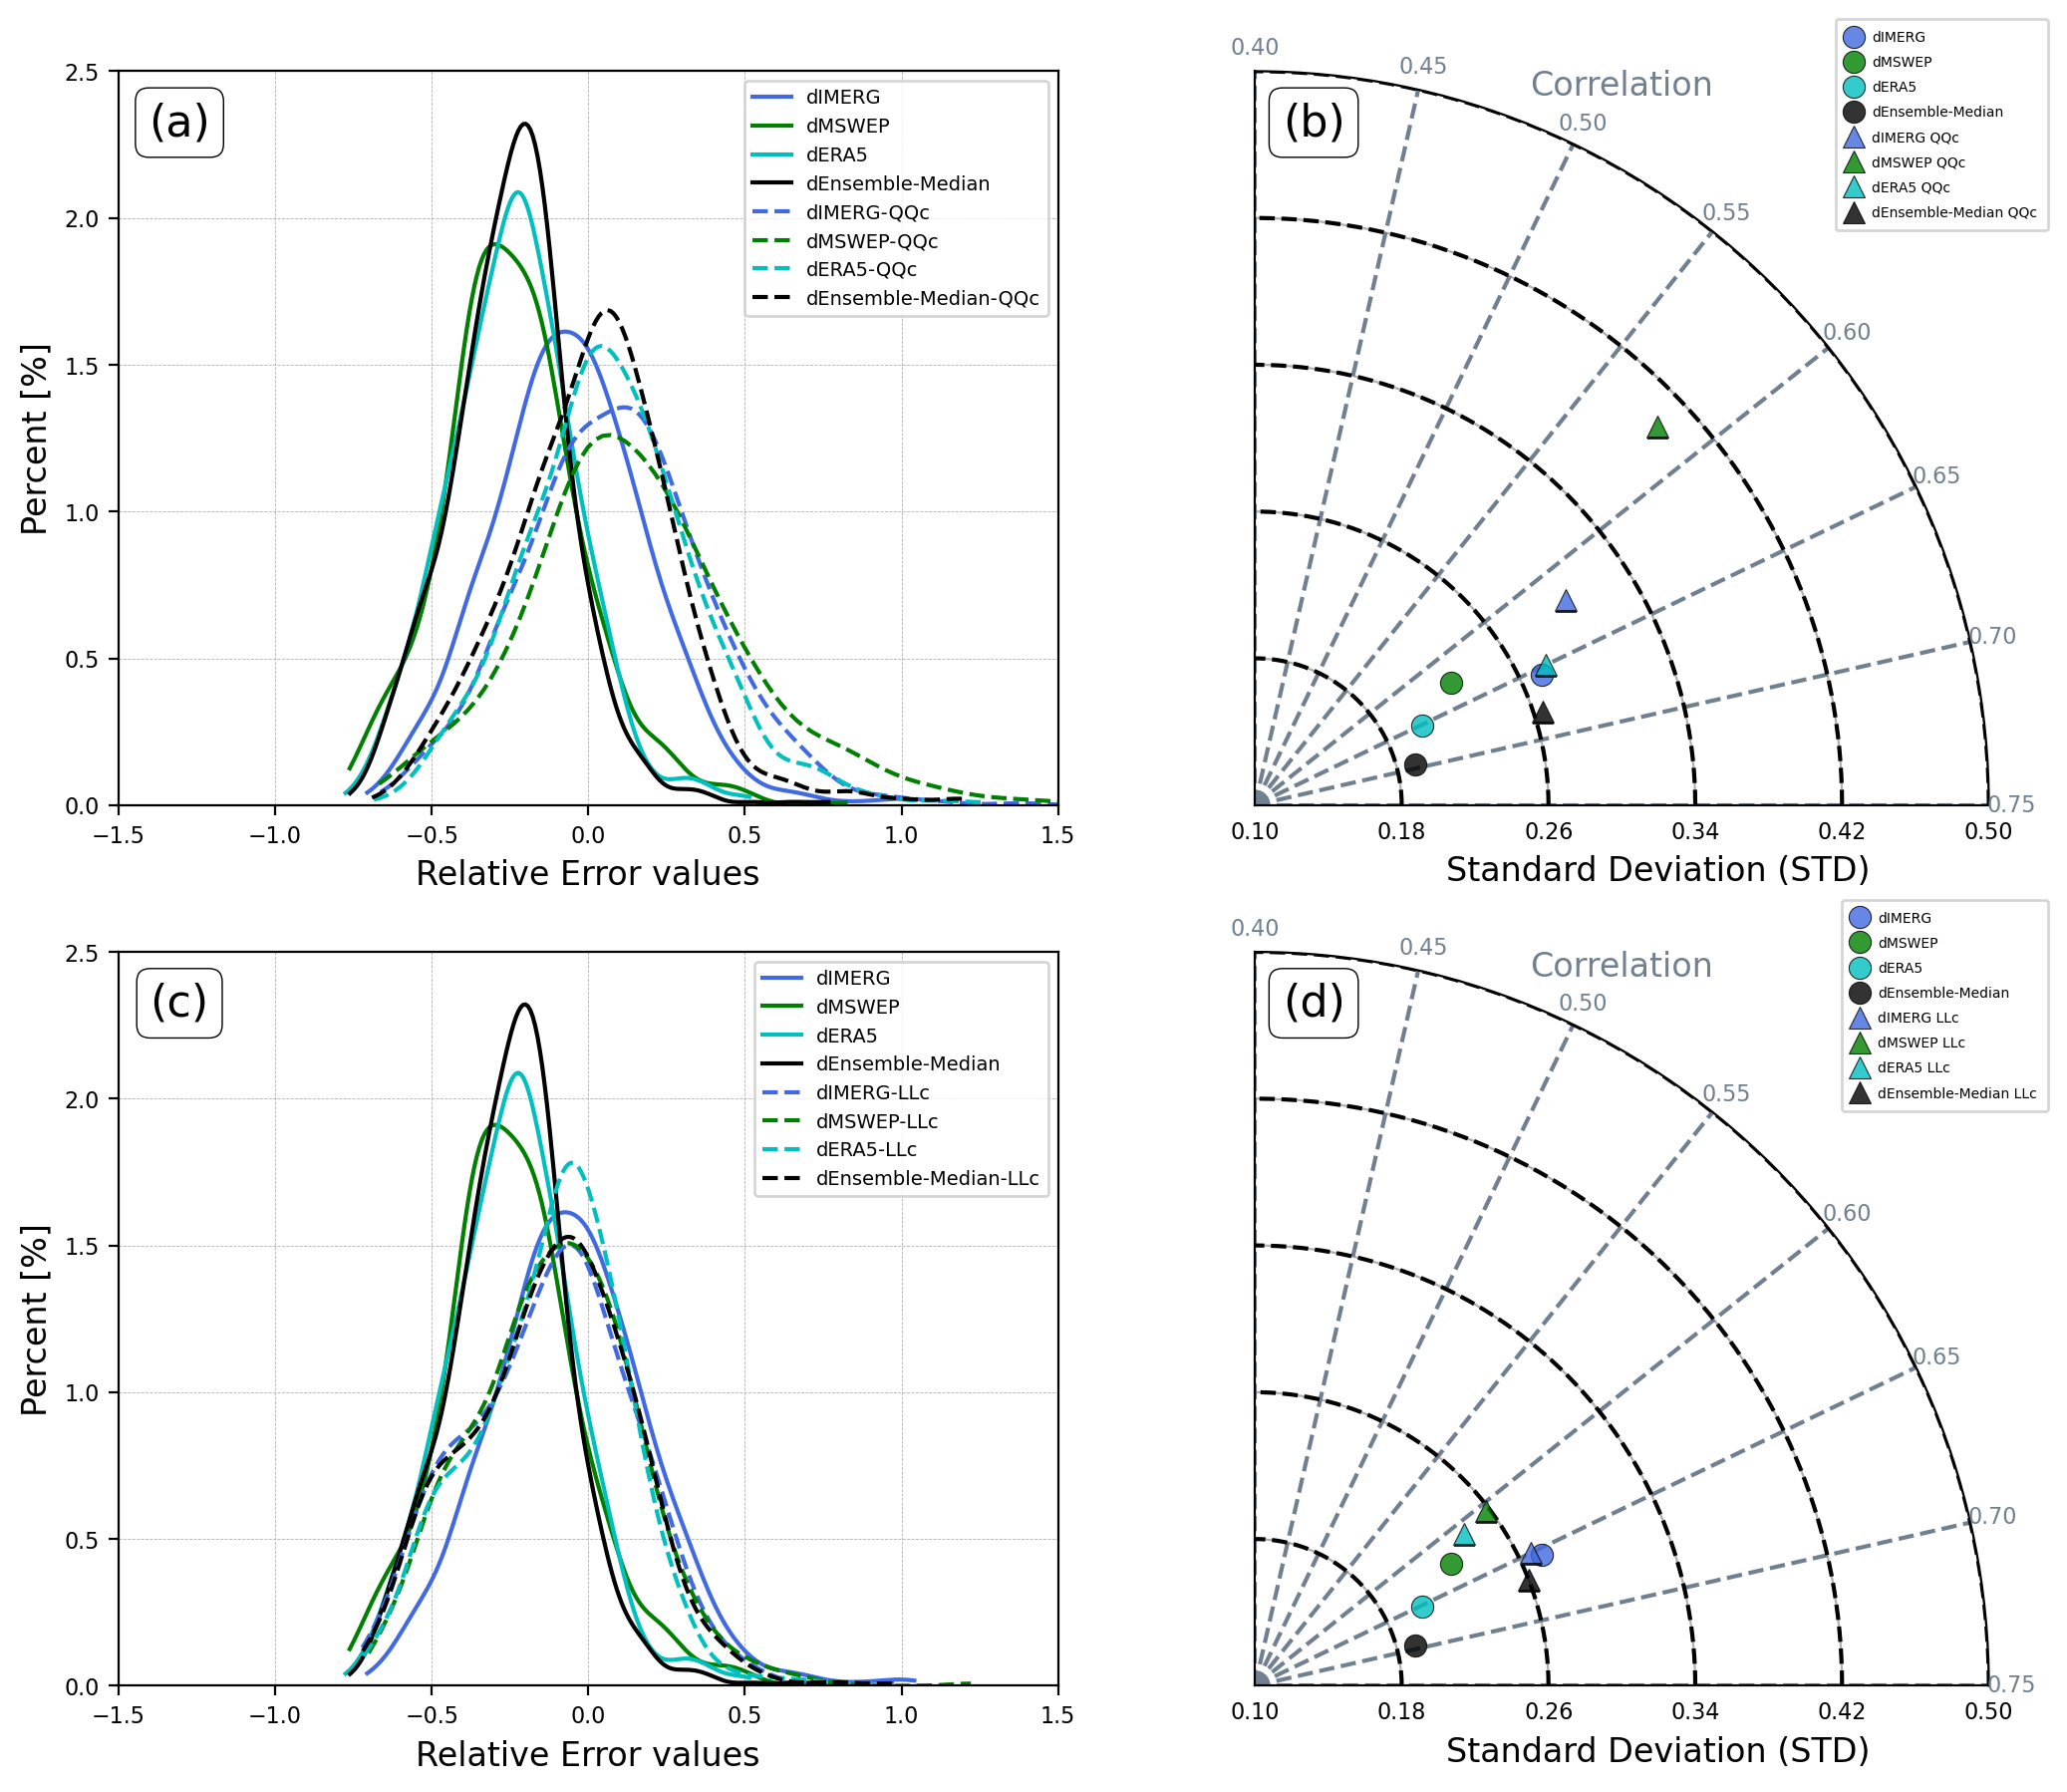

In [30]:
markers_T = ['o', 'o', 'o', 'o', '^', '^', '^', '^']
fig = plt.figure(figsize=(11,9),dpi=200)
gs = gridspec.GridSpec(2,2)

# =====================================================================================================================================================
# =====================================================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(DF_IMERG.RER,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_IMERG.RER)), np.nanmax(np.array(DF_IMERG.RER))))
sns.kdeplot(DF_MSWEP.RER,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_MSWEP.RER)), np.nanmax(np.array(DF_MSWEP.RER))))
sns.kdeplot(DF_ERA5.RER,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_ERA5.RER)), np.nanmax(np.array(DF_ERA5.RER))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RED,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RED))))

sns.kdeplot(DF_IMERG_QQc.RED,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-QQc',
            clip=(np.nanmin(np.array(DF_IMERG_QQc.RED)), np.nanmax(np.array(DF_IMERG_QQc.RED))))
sns.kdeplot(DF_MSWEP_QQc.RED,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-QQc',
            clip=(np.nanmin(np.array(DF_MSWEP_QQc.RED)), np.nanmax(np.array(DF_MSWEP_QQc.RED))))
sns.kdeplot(DF_ERA5_QQc.RED,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-QQc',
            clip=(np.nanmin(np.array(DF_ERA5_QQc.RED)), np.nanmax(np.array(DF_ERA5_QQc.RED))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN_QQc.RED,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-QQc',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN_QQc.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN_QQc.RED))))

ax1.set_ylabel('Percent [%]',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.text(0.065, 0.93, '(a)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_OBS_QQc.STD.values, RSR_OBS_QQc.CORR.values, RSR_OBS_QQc.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

# plt.legend(fontsize=5, ncol=1, loc='upper right', bbox_to_anchor=(1.09, 1.08))
plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

# --- LABELS ---
# ax1.text(0.55, -0.09, "Mean Absolute Relative Error (MARE)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)
ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.text(0.08, 0.93, '(b)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# =====================================================================================================================================================
# =====================================================================================================================================================
ax1 = plt.subplot(gs[1, 0])

sns.kdeplot(DF_IMERG.RER,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_IMERG.RER)), np.nanmax(np.array(DF_IMERG.RER))))
sns.kdeplot(DF_MSWEP.RER,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_MSWEP.RER)), np.nanmax(np.array(DF_MSWEP.RER))))
sns.kdeplot(DF_ERA5.RER,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_ERA5.RER)), np.nanmax(np.array(DF_ERA5.RER))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RED,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RED))))

sns.kdeplot(DF_IMERG_LLc.RED,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-LLc',
            clip=(np.nanmin(np.array(DF_IMERG_LLc.RED)), np.nanmax(np.array(DF_IMERG_LLc.RED))))
sns.kdeplot(DF_MSWEP_LLc.RED,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-LLc',
            clip=(np.nanmin(np.array(DF_MSWEP_LLc.RED)), np.nanmax(np.array(DF_MSWEP_LLc.RED))))
sns.kdeplot(DF_ERA5_LLc.RED,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-LLc',
            clip=(np.nanmin(np.array(DF_ERA5_LLc.RED)), np.nanmax(np.array(DF_ERA5_LLc.RED))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN_LLc.RED,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-LLc',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN_LLc.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN_LLc.RED))))

ax1.set_ylabel('Percent [%]',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.text(0.065, 0.93, '(c)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# =========================================================================================================================
ax1 = plt.subplot(gs[1, 1], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_OBS_LLc.STD.values, RSR_OBS_LLc.CORR.values, RSR_OBS_LLc.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

# plt.legend(fontsize=5, ncol=1, loc='upper right', bbox_to_anchor=(1.09, 1.08))
plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

# --- LABELS ---
# ax1.text(0.55, -0.09, "Mean Absolute Relative Error (MARE)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)
ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.text(0.08, 0.93, '(d)', 
            fontsize=16, ha='center', va='center',
            transform=ax1.transAxes, zorder=20,
            bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="white", 
                alpha=1,
                edgecolor="black",
                linewidth=0.5))

# ============================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.1, hspace=0.2)

# salida = '../figures/Article_down/Scatter_FOCUS_RE_corected.png'
# print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [31]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'DEM','Italy_dem_800.geojson')) 
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [32]:
italy_geom = ITALY.union_all()

## Median Downscaled

In [33]:
ENS_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_ENSEMBLE')

dir_in = os.path.join(ENS_base,f'ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median.nc')
DATA = xr.open_dataset(dir_in)
lon2d, lat2d, = np.meshgrid(DATA.lon, DATA.lat)
mask_italy = sv.contains(italy_geom, lon2d, lat2d)

MEVd_Median = DATA.Mev_d.where(mask_italy)

# Median QQc Correction

In [34]:
ENS_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected','PARAM','QQc')

dir_in = os.path.join(ENS_base,f'ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median_QQc_0007.nc')
DATA = xr.open_dataset(dir_in)
mask_italy = sv.contains(italy_geom, lon2d, lat2d)

MEVd_Median_QQc = DATA.Mev_d.where(mask_italy)

## Median LLc Correction

In [35]:
ENS_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected','PARAM','LLc')

dir_in = os.path.join(ENS_base,f'ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median_LLc_0007.nc')
DATA = xr.open_dataset(dir_in)
mask_italy = sv.contains(italy_geom, lon2d, lat2d)

MEVd_Median_LLc = DATA.Mev_d.where(mask_italy)

In [36]:
ISO_names = np.unique(METADATA.ISO.values)

lats, lons = [], []
QUANTILE = []

for rr in range(len(ISO_names)):
    region_ISO = ISO_names[rr]

    INFO_dict = {}
    WEIBULL_dict = {}
    QUANTILES_dict = {}

    # print(f'{rr+1}: {region_ISO}')

    METADATA_clear = METADATA[METADATA['ISO']==region_ISO].reset_index(inplace=False)

    for nn in range(len(METADATA_clear)):#len(METADATA_clear)
        filename = f'{METADATA_clear['File'].values[nn]}'
        lat_obs = METADATA_clear['Lat'][nn]
        lon_obs = METADATA_clear['Lon'][nn]
        elev_obs = METADATA_clear['DEM_Elevation'][nn]

        OBS_pd = pd.read_csv(os.path.join(obs_base, 'Weibull', '1dy', region_ISO, filename))
        OBS_pd = OBS_pd[(OBS_pd['Year']>=2002)&(OBS_pd['Year']<=2023)].reset_index(drop=True)
        
        if len(OBS_pd) == 0:
            continue

        else:
            OBS_N = OBS_pd['N'].values
            OBS_C = OBS_pd['C'].values
            OBS_W = OBS_pd['W'].values
            OBS_Y = OBS_pd['Year'].values

            mask = ~np.isnan(OBS_N)

            OBS_N = OBS_N[mask]
            OBS_C = OBS_C[mask]
            OBS_W = OBS_W[mask]
            OBS_Y = OBS_Y[mask]

            if len(OBS_Y) >= 8: # greather than 8 years

                x0 = np.nanmean(OBS_C)
                OBS_Q, flag = DOWN_raw.mev_quant_update(Fi, x0, OBS_N, OBS_C, OBS_W, thresh=1)
                OBS_Q2 = np.where(flag, OBS_Q, np.nan)

                lats.append(lat_obs)
                lons.append(lon_obs)
                QUANTILE.append(OBS_Q2[3])

Quantile_pd = pd.DataFrame({'lat':lats,'lon':lons,'Quantile':QUANTILE})
Quantile_clear = Quantile_pd[Quantile_pd['Quantile']<500]
Q_norm = (Quantile_clear['lat'].values - np.nanmin(Quantile_clear['lat'].values))/(np.nanmax(Quantile_clear['lat'].values)-np.nanmin(Quantile_clear['lat'].values)) *2

In [37]:
Mev_levels = np.arange(60, 390, 10)
Mev_cmap = plt.cm.Spectral_r
norm = BoundaryNorm(Mev_levels, ncolors=Mev_cmap.N, clip=True)

../figures/Article_down/Bias_correction_PARAM.png


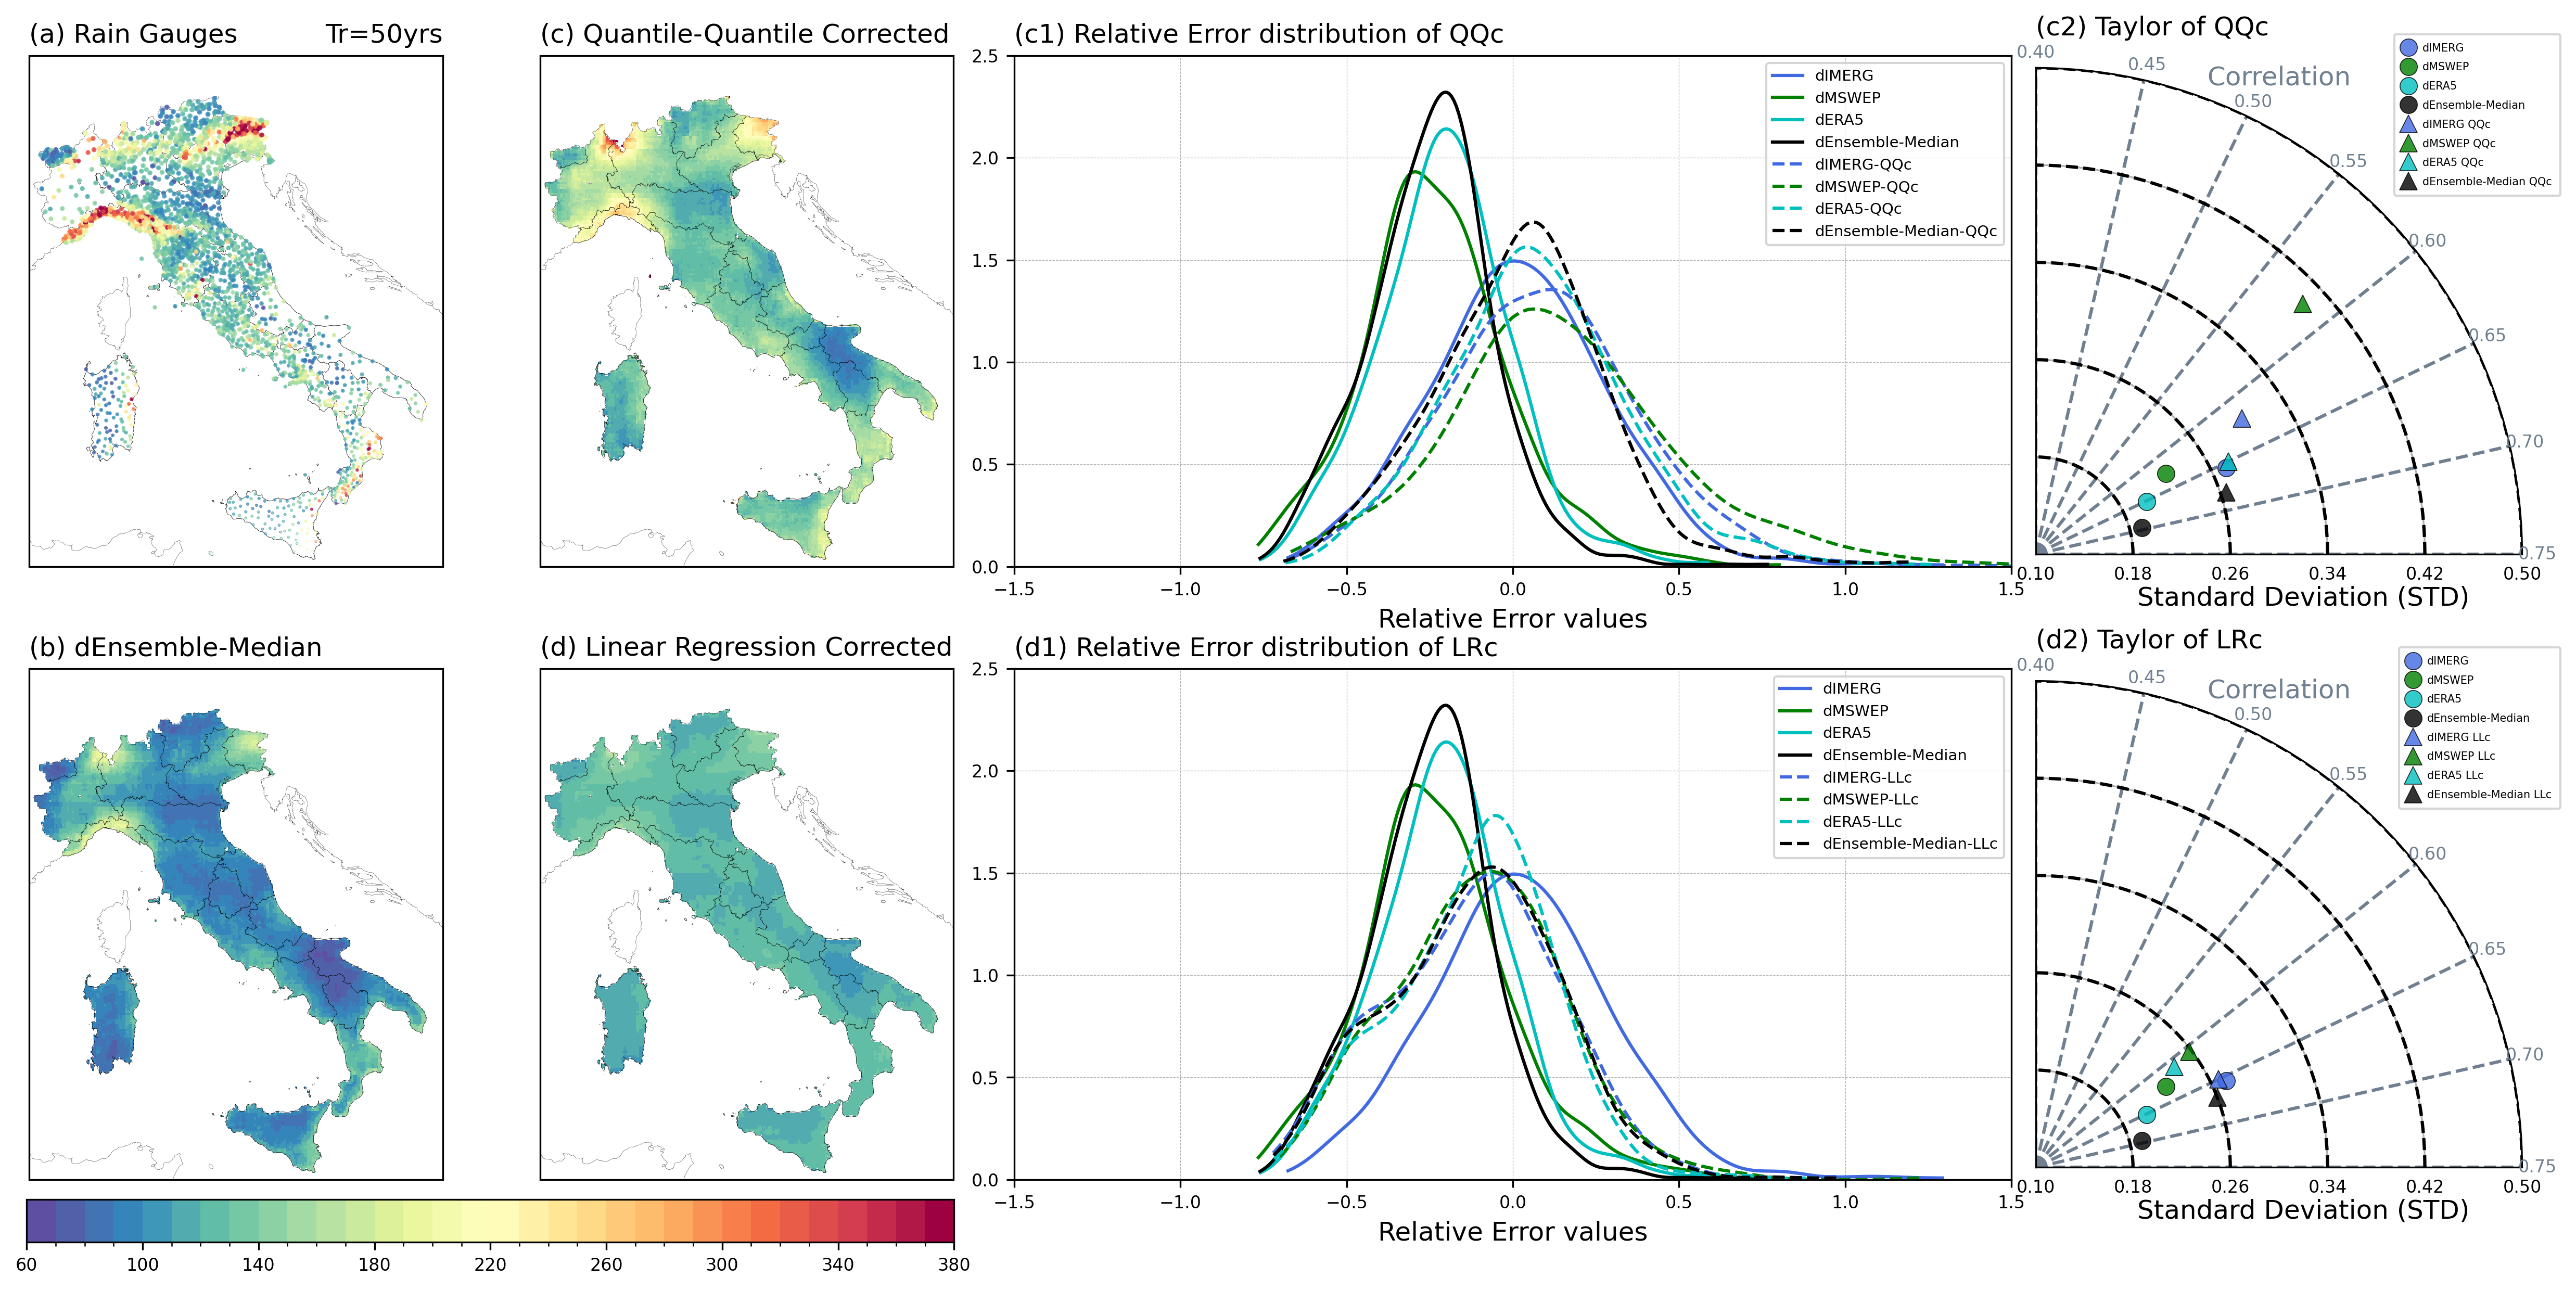

In [ ]:
pos = 3

proj = ccrs.PlateCarree()

Mev_cmap = plt.cm.Spectral_r
diff_map = plt.cm.coolwarm_r
norm = mcolors.BoundaryNorm(boundaries=Mev_levels, ncolors=Mev_cmap.N)
# norm_diff = mcolors.BoundaryNorm(boundaries=Diff_levels, ncolors=diff_map.N)

fig = plt.figure(figsize=(18,8),dpi=300)
gs = gridspec.GridSpec(2,5)

# ===========================================================================================================================================================================
# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
# ax1.add_feature(cfeature.BORDERS,linewidth=0.2,edgecolor='black',zorder=4)
im = REGIONS.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
a1 = ax1.scatter(Quantile_clear['lon'].values, Quantile_clear['lat'].values, c=Quantile_clear['Quantile'].values, s=Q_norm, alpha=0.8,cmap=Mev_cmap,norm=norm, zorder=10)

ax1.set_title('(a) Rain Gauges', loc='left', fontsize=12)
ax1.set_title('Tr=50yrs', loc='right', fontsize=12)

# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
# ax1.add_feature(cfeature.BORDERS,linewidth=0.2,edgecolor='black',zorder=4)
im = REGIONS.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
# DEM.plot(facecolor='None', edgecolor='k', ax=ax1, linewidth=0.1, zorder=21, alpha=0.3)
a1 = ax1.pcolormesh(lon2d, lat2d, MEVd_Median_QQc[pos,:,:], cmap=Mev_cmap, norm=norm)

# cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04, orientation='horizontal')
# cbar.ax.tick_params(labelsize=6) 

ax1.set_title('(c) Quantile-Quantile Corrected', loc='left', fontsize=12)

# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 2:4])
ax1.set_aspect('auto')

sns.kdeplot(DF_IMERG.RED,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_IMERG.RED)), np.nanmax(np.array(DF_IMERG.RED))))
sns.kdeplot(DF_MSWEP.RED,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_MSWEP.RED)), np.nanmax(np.array(DF_MSWEP.RED))))
sns.kdeplot(DF_ERA5.RED,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_ERA5.RED)), np.nanmax(np.array(DF_ERA5.RED))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RED,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RED))))

sns.kdeplot(DF_IMERG_QQc.RED,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-QQc',
            clip=(np.nanmin(np.array(DF_IMERG_QQc.RED)), np.nanmax(np.array(DF_IMERG_QQc.RED))))
sns.kdeplot(DF_MSWEP_QQc.RED,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-QQc',
            clip=(np.nanmin(np.array(DF_MSWEP_QQc.RED)), np.nanmax(np.array(DF_MSWEP_QQc.RED))))
sns.kdeplot(DF_ERA5_QQc.RED,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-QQc',
            clip=(np.nanmin(np.array(DF_ERA5_QQc.RED)), np.nanmax(np.array(DF_ERA5_QQc.RED))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN_QQc.RED,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-QQc',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN_QQc.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN_QQc.RED))))

ax1.set_ylabel('',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.set_title('(c1) Relative Error distribution of QQc', loc='left', fontsize=12)

# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 4], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_OBS_QQc.STD.values, RSR_OBS_QQc.CORR.values, RSR_OBS_QQc.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.set_title('(c2) Taylor of QQc', loc='left', fontsize=12, pad=15)

# ===========================================================================================================================================================================
# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
# ax1.add_feature(cfeature.BORDERS,linewidth=0.2,edgecolor='black',zorder=4)
im = REGIONS.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
# DEM.plot(facecolor='None', edgecolor='k', ax=ax1, linewidth=0.1, zorder=21, alpha=0.3)
a1 = ax1.pcolormesh(lon2d, lat2d, MEVd_Median[pos,:,:], cmap=Mev_cmap, norm=norm)

# cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04, orientation='horizontal')
# cbar.ax.tick_params(labelsize=6) 

ax1.set_title('(b) dEnsemble-Median', loc='left', fontsize=12)


# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
# ax1.add_feature(cfeature.BORDERS,linewidth=0.2,edgecolor='black',zorder=4)
im = REGIONS.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
# DEM.plot(facecolor='None', edgecolor='k', ax=ax1, linewidth=0.1, zorder=21, alpha=0.3)
a1 = ax1.pcolormesh(lon2d, lat2d, MEVd_Median_LLc[pos,:,:], cmap=Mev_cmap, norm=norm)

# cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04, orientation='horizontal')
# cbar.ax.tick_params(labelsize=6) 

ax1.set_title('(d) Linear Regression Corrected', loc='left', fontsize=12)

# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[1, 2:4])

sns.kdeplot(DF_IMERG.RED,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG',
            clip=(np.nanmin(np.array(DF_IMERG.RED)), np.nanmax(np.array(DF_IMERG.RED))))
sns.kdeplot(DF_MSWEP.RED,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP',
            clip=(np.nanmin(np.array(DF_MSWEP.RED)), np.nanmax(np.array(DF_MSWEP.RED))))
sns.kdeplot(DF_ERA5.RED,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5',
            clip=(np.nanmin(np.array(DF_ERA5.RED)), np.nanmax(np.array(DF_ERA5.RED))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN.RED,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN.RED))))

sns.kdeplot(DF_IMERG_LLc.RED,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dIMERG-LLc',
            clip=(np.nanmin(np.array(DF_IMERG_LLc.RED)), np.nanmax(np.array(DF_IMERG_LLc.RED))))
sns.kdeplot(DF_MSWEP_LLc.RED,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dMSWEP-LLc',
            clip=(np.nanmin(np.array(DF_MSWEP_LLc.RED)), np.nanmax(np.array(DF_MSWEP_LLc.RED))))
sns.kdeplot(DF_ERA5_LLc.RED,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dERA5-LLc',
            clip=(np.nanmin(np.array(DF_ERA5_LLc.RED)), np.nanmax(np.array(DF_ERA5_LLc.RED))))
sns.kdeplot(DF_ENSEMBLE_MEDIAN_LLc.RED,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'dEnsemble-Median-LLc',
            clip=(np.nanmin(np.array(DF_ENSEMBLE_MEDIAN_LLc.RED)), np.nanmax(np.array(DF_ENSEMBLE_MEDIAN_LLc.RED))))

ax1.set_ylabel('',fontsize=12)
ax1.set_xlabel('Relative Error values',fontsize=12)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.set_title('(d1) Relative Error distribution of LRc', loc='left', fontsize=12)

# =========================================================================================================================
ax1 = plt.subplot(gs[1, 4], polar=True)

rmin = 0.1
rmax = 0.5

c_min = 0.4
c_max = 0.75
correlations = np.arange(c_min, c_max + 0.05, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax1.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax1.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE MARE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax1.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax1.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co, ma in zip(RSR_OBS_LLc.STD.values, RSR_OBS_LLc.CORR.values, RSR_OBS_LLc.Dataset.values, colors_T, markers_T):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax1.plot(theta, rmse_val, ma, markersize=8, 
            markeredgecolor='black',
            markeredgewidth=0.4,
            alpha=0.8, label=f'{lab}', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax1.set_thetamin(0)
ax1.set_thetamax(90)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_rmin(rmin)
ax1.set_rmax(rmax)

# --- RADIAL TICKS ---
ax1.set_yticks(radial_ticks)
ax1.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax1.grid(True)

plt.legend(fontsize=5, 
            ncol=1, 
            loc='upper right', 
            bbox_to_anchor=(1.09, 1.08),
            handlelength=1.0,      # Longitud de la línea del símbolo
            handletextpad=0.8,     # Espacio entre símbolo y texto
            borderpad=0.8,         # Padding interno
            labelspacing=0.8)      # Espacio entre etiquetas

# --- LABELS ---
ax1.text(0.55, -0.09, "Standard Deviation (STD)", transform=ax1.transAxes,ha="center", va="center", fontsize=12)

ax1.text(0.5, 0.98, "Correlation", transform=ax1.transAxes,
        ha="center", va="center", rotation=0, fontsize=12, color='slategrey')

ax1.set_title('(d2) Taylor of LRc', loc='left', fontsize=12, pad=15)

# ===========================================================================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.05, hspace=0.2)

cbar_ax = fig.add_axes([0.062, 0.0, 0.33, 0.034])
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=8)

# cbar_ax = fig.add_axes([0.66, 0.09, 0.29, 0.038])
# cbar = fig.colorbar(a2, cax=cbar_ax, orientation='horizontal')
# cbar.ax.tick_params(labelsize=8)

# ===========================================================================================================================================================================
salida = '../figures/Article_down/Bias_correction_PARAM.png'
print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)